In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
from scipy.stats import linregress
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser

### Plan

Need to compare New Production, CO2 flux and SST at different locations and for different timescale resolutions. 
Assess which is the best Ensemble for Each of these.


What do we need

- Work in mols.


- CAFE New Production (Need to make detritus calculation)
- CO2 flux 

- New Production estimates
- Chlor A in mg CHL? 
- Landschutzer CO2 flux estimate (How about DELTA pCO2?)
- Reynolds OISST product


- And then detrend and deseasonalise to get different data product resolutions.

- Plot all ensembles over a Year?


In [4]:
# Assumes data was loaded previously in 12 Validation run
use_dask=True
run_chl=False

In [5]:
if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    from dask.distributed import Client,Scheduler
    from dask_jobqueue import SLURMCluster
    
    cluster = SLURMCluster(cores=2,memory="16GB")
    client = Client(cluster)
    cluster.scale(cores=4)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

In [6]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-20,20))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

<xarray.Dataset>
Dimensions:          (time: 720, ensemble: 96, st_ocean: 50, lat: 98, lon: 170, scalar_axis: 1)
Coordinates:
  * ensemble         (ensemble) int32 1 2 3 4 5 6 7 8 ... 90 91 92 93 94 95 96
  * scalar_axis      (scalar_axis) float64 0.0
  * st_ocean         (st_ocean) float64 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * time             (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon              (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat              (lat) float64 -19.36 -18.59 -17.85 ... 17.85 18.59 19.36
Data variables: (12/33)
    adic             (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    alk              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    caco3            (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    caco3_sediment   (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    det              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    det_sediment     (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    ...               ...
    surface_o2       (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    surface_phy      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    surface_zoo      (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    total_aco2_flux  (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    total_co2_flux   (time, ensemble, scalar_axis) float32 dask.array<chunksize=(1, 96, 1), meta=np.ndarray>
    zoo              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Sun Dec  1 23:38:56 2019
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [7]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-20,20))
phys_eqpac

<xarray.Dataset>
Dimensions:                 (time: 720, ensemble: 96, st_ocean: 50, lat: 98, lon: 170, sw_ocean: 50, lon_x: 360, lat_x: 300)
Coordinates:
  * ensemble                (ensemble) int32 1 2 3 4 5 6 7 ... 91 92 93 94 95 96
  * st_ocean                (st_ocean) float64 5.0 15.0 ... 5.499e+03 5.831e+03
  * sw_ocean                (sw_ocean) float64 10.0 20.0 ... 5.665e+03 6e+03
  * time                    (time) object 1960-01-16 12:00:00 ... 2019-12-16 ...
  * lon                     (lon) float64 120.5 121.5 122.5 ... 288.5 289.5
  * lon_x                   (lon_x) float64 81.0 82.0 83.0 ... 438.0 439.0 440.0
  * lat                     (lat) float64 -19.36 -18.59 -17.85 ... 18.59 19.36
  * lat_x                   (lat_x) float64 -77.75 -77.51 -77.26 ... 89.55 90.0
Data variables: (12/22)
    age_global              (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    cfc_11                  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    cfc_12                  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    eta_t                   (time, ensemble, lat, lon) float32 dask.array<chunksize=(1, 96, 98, 170), meta=np.ndarray>
    neutral_diffusion_salt  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    neutral_diffusion_temp  (time, ensemble, st_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
    ...                      ...
    tx_trans_gm             (time, ensemble, st_ocean, lat, lon_x) float32 dask.array<chunksize=(1, 96, 3, 98, 360), meta=np.ndarray>
    ty_trans                (time, ensemble, st_ocean, lat_x, lon) float32 dask.array<chunksize=(1, 96, 3, 300, 170), meta=np.ndarray>
    ty_trans_gm             (time, ensemble, st_ocean, lat_x, lon) float32 dask.array<chunksize=(1, 96, 3, 300, 170), meta=np.ndarray>
    u                       (time, ensemble, st_ocean, lat_x, lon_x) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    v                       (time, ensemble, st_ocean, lat_x, lon_x) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    wt                      (time, ensemble, sw_ocean, lat, lon) float32 dask.array<chunksize=(1, 96, 3, 98, 170), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Apr 23 08:05:39 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [8]:
# Load OBS

land_co2=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc')/365 #g/m2/day
land_co2=(land_co2.fgco2_smoothed.sel(lon=slice(120,290),lat=slice(-20,20))/12)*-1000 #mmol/m2/day to match cafe. (ingassing is positive, outgassing neg)
rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc')
rey_sst=rey_sst.sst.sel(lon=slice(120,290),lat=slice(-20,20))

In [9]:
#sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.eqpac.nc')
#sst=xr.open_dataset('../processed_data/rey_eqpac_sst_rg.nc').__xarray_dataarray_variable__
npp=xr.open_dataset('../processed_data/npp_rg/avg_npp_rg_cafe.nc').avg_npp
npp_vgpm=xr.open_dataset('../processed_data/npp_rg/avg_npp_rg_vgpm.nc').avg_npp
npp_cbpm=xr.open_dataset('../processed_data/npp_rg/avg_npp_rg_cbpm.nc').avg_npp
npp_eppley=xr.open_dataset('../processed_data/npp_rg/avg_npp_rg_eppley.nc').avg_npp
chl=xr.open_dataset('../processed_data/obs/TPCA_month_regrid.nc').__xarray_dataarray_variable__
chl_modis=xr.open_dataset('../processed_data/obs/TPCA_modis_month_regrid.nc').__xarray_dataarray_variable__

tpca=xr.open_dataset('../processed_data/obs/TPCA_month_regrid.nc').__xarray_dataarray_variable__#.mean(dim='time').plot(vmin=0,vmax=0.3)
tpca_sw=xr.open_dataset('../processed_data/obs/TPCA_sw_month_regrid.nc').__xarray_dataarray_variable__
tpca_mod=xr.open_dataset('../processed_data/obs/TPCA_modis_month_regrid.nc').__xarray_dataarray_variable__

In [10]:
fr=xr.open_dataset('../processed_data/fratios_rg.nc')

In [11]:
np_obs=(npp/12)*fr.laws2011a

In [12]:
# F-ratio / export algo calcs
# STILL NEED TO MERGE THE TPCA ALGOS.

if run_chl==True:
    chl=tpca_mod
    #CALC DIFFERENT f-ratio ALGOS. Need to multiply these ratios with the new prodution rate to get export flux.
    zeu1= 34*chl**-0.39#lee 2007
    zeu2=38*chl**-0.428#Morel 1989

    pe_dunne=-0.0101*rey_sst+0.0582*np.log(npp/zeu1)+0.419
    pe_dunne2=-0.0101*rey_sst+0.0582*np.log(npp/zeu2)+0.419
    pe_dunne3=0.0081*rey_sst+0.0668*np.log(chl/zeu2)+0.426
    f_ratio=(0.62-(0.02*rey_sst))
    th_e_ratio=(0.23*np.exp(-0.08*rey_sst))
    laws2011a=((0.5857-0.0165*rey_sst)*npp)/(51.7+npp)
    laws2011b=0.04756*(0.78-((0.43*rey_sst)/30))*npp**0.307 #avgnpp

    trim=convert_trim_fratios(trim_path='../external_data/fratios/SIMPLE_TRIM_output.nc',
                             regrid_path='../processed_data/rey_eqpac_sst_rg.nc')

In [13]:
#bgcdatvs=xr.open_dataset('../processed_data/model_proc_temp/epac_bgc.nc')
#physdatvs=xr.open_dataset('../processed_data/model_proc_temp/epac_phys.nc')

bgcdatvs_allens=xr.open_dataset('../processed_data/model_proc_temp/epac_bgc_all_ensembles2.nc')
physdatvs_allens=xr.open_dataset('../processed_data/model_proc_temp/epac_phys_all_ensembles.nc')

# Combine BGC and physics DFs.
physdatvs_allens['time']=bgcdatvs_allens['time']
bgcdatvs_allens['temp']=physdatvs_allens['temp']
bgcdatvs_allens['sst']=physdatvs_allens['sst']

In [14]:
bgcdatvs_allens

<xarray.Dataset>
Dimensions:         (ensemble: 96, time: 720, lon: 170, lat: 98)
Coordinates:
  * ensemble        (ensemble) int32 1 2 3 4 5 6 7 8 ... 89 90 91 92 93 94 95 96
  * time            (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon             (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat             (lat) float64 -19.36 -18.59 -17.85 ... 17.85 18.59 19.36
    st_ocean        float64 ...
Data variables:
    pprod_gross_2d  (time, ensemble, lat, lon) float32 ...
    stf10           (time, ensemble, lat, lon) float32 ...
    stf07           (time, ensemble, lat, lon) float32 ...
    det_export      (time, ensemble, lat, lon) float32 ...
    trim_export_2d  (time, ensemble, lat, lon) float64 ...
    laws_export_2d  (time, ensemble, lat, lon) float64 ...
    temp            (time, ensemble, lat, lon) float32 ...
    sst             (time, ensemble, lat, lon) float32 ...
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Sun Dec  1 23:38:56 2019
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

In [122]:
# Convert Data for plotting
sst_cafe=bgcdatvs_allens.sst.sel(time=slice('2000-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('2000-01-01','2020-01-01'))
co2_cafe=bgcdatvs_allens.stf10.sel(time=slice('2000-01-01','2020-01-01'))
co2_cafe_natural=bgcdatvs_allens.stf07.sel(time=slice('2000-01-01','2020-01-01'))
co2_land=land_co2.sel(time=slice('2000-01-01','2020-01-01'))
co2_rodenbeck=(xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid.nc').sel(lon=slice(120,290),lat=slice(-20,20)).co2flux_ocean/12)*1000 #to mmolC


npp_cafe_25=bgcdatvs_allens.det_export.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01'))*6.625
npp_cafe_23=bgcdatvs_allens.det_export.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np2_cafe=bgcdatvs_allens.trim_export_2d.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np_dat=(np_obs.sel(time=slice('1990-01-01','2020-01-01')))

## Add a few custom functions ive been making.
wrap functions to wrap functions that wrap functions
who wraps the wrapper for the wrapper? 

In [16]:
#Ok how does this error look through time for different parts of the Pacific.
def plot_pacific_boxes(var_a,
                 var_b,
                 var_a_name,
                 var_b_name,
                 units,
                 title,
                 var_c=None,
                 var_d=None,
                 var_c_name=None,
                 var_d_name=None,
                 error=False,
                 sdate='1990-01-01',
                 edate='2020-01-01',
                 detrend=False,
                 deseasonalise=False,
                 plot_decomposition=False,
                 keep_intercept_values=True,
                 rolling=False):

    labels=['Whole EqPac',
           'SouthEast EqPac',
           'NorthEast EqPac',
            'All East EqPac',
            'Central EqPac',
            'Dateline EqPac',
            'FarWest EqPac']

    locs=[[-15,15,150,275],
          [-15,0,225,250],
          [0,15,225,250],
          [-15,15,225,250],
          [-15,15,200,225],
          [-15,15,175,200],
          [-15,15,150,175]]

    # terrible solution but works to plot all
    var_a_actual=var_a
    if var_b is not None:var_b_actual=var_b
    
    if detrend==True:
        var_a_detrended=xarray_detrend(var_a_actual,keep_intercept_values=keep_intercept_values)
        if var_b is not None:var_b_detrended=xarray_detrend(var_b_actual,keep_intercept_values=keep_intercept_values)
            
        var_a_actual=var_a_detrended
        if var_b is not None:var_b_actual=var_b_detrended
        if var_c is not None:var_c=xarray_detrend(var_c,keep_intercept_values=keep_intercept_values)
        if var_d is not None:var_d=xarray_detrend(var_d,keep_intercept_values=keep_intercept_values)
        
    if deseasonalise==True:
        var_a_deseasonalised=deseasonaliser(var_a_actual,rolling=rolling)
        if var_b is not None:var_b_deseasonalised=deseasonaliser(var_b_actual,rolling=rolling)
        
        var_a_actual=var_a_deseasonalised
        if var_b is not None:var_b_actual=var_b_deseasonalised
        
        if var_c is not None:var_c=deseasonaliser(var_c,rolling=rolling)
        if var_d is not None:var_d=deseasonaliser(var_d,rolling=rolling)
        
    plt.figure(figsize=(20,12))

    
    for i,latlon in enumerate(locs):
        print(i)

        if i==0:
            ax=plt.subplot(3,1,1)
        else:
            ax=plt.subplot(3,3,3+i)



            
        var_a_loc=var_a_actual.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
        plt.plot(var_a_loc.time,var_a_loc,c='k',linewidth=2)
        
        if var_b is not None: 
            var_b_loc=var_b_actual.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
            plt.plot(var_b_loc.time,var_b_loc,c='r',linewidth=2)

        leglabels=[None,None,None,None]
        if plot_decomposition==True:
            
            if detrend==True:
                if keep_intercept_values!=False:
                    # Plot the raw vesion because we do plot the 
                    plt.plot(var_a_loc.time,var_a.sel(
                        lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon']),c='k',linewidth=2,linestyle='--')
                    leglabels[0]='Raw'
                    plot_tr=True
                #if plot_tr==True:
                #    m, b, _ = stats.linregress(x, y)
                #    detrend_y=y-(m*x + b)
                
                if var_b is not None:plt.plot(var_b_loc.time,var_b.sel(
                    lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon']),c='r',linewidth=2,linestyle='--')
                    #leglabels[1]='Raw'
                    
                
            if deseasonalise==True:
                # Assumes Detrended is already On
                plt.plot(var_a_loc.time,var_a_detrended.sel(
                    lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon']),c='k',linewidth=2,linestyle=':')
                leglabels[1]='Detrended'
                if var_b is not None: plt.plot(var_b_loc.time,var_b_detrended.sel(
                    lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon']),c='r',linewidth=2,linestyle=':')

                
        if var_c is not None:
            var_c_loc=((var_c).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon']))
            plt.plot(var_c_loc.time,var_c_loc,c='g',linewidth=2)
         
        if var_d is not None:
            var_d_loc=((var_d).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon']))
            plt.plot(var_d_loc.time,var_d_loc,c='m',linewidth=2)
            
        legs=[var_a_name,var_b_name,var_c_name,var_d_name]
        for l in leglabels:
            legs.append(l)
        ax.legend(legs)
        ax.set_xlim([np.datetime64(sdate),np.datetime64(edate)])
        ax.set_ylabel(units)
        #ax.set_title('CO2 flux comparisons')
        ax.set_title(title+labels[i])

    plt.tight_layout()
    plt.show()

#UNITS surface_phy=mmol/m^3
# output should me mg Chl M3

# Convert Data for plotting
#sst_cafe
#sst_rey
#co2_cafe
#co2_land
#co2_rodenbeck23
np2_cafe
np_dat

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:67: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,


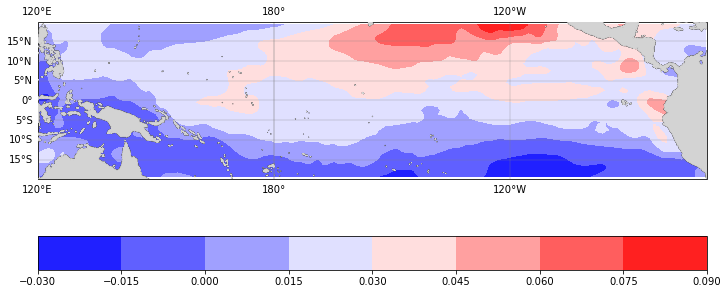

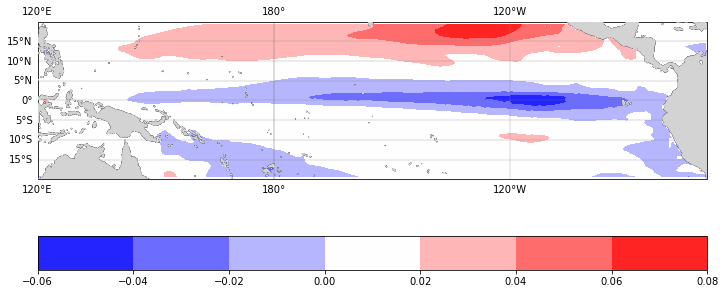

In [17]:
# Were gonna need to make a 3way. 

def plot_pacific(dat):

    fig = plt.figure(figsize=(12,7))

    # this declares a recentered projection for Pacific areas
    proj = ccrs.PlateCarree(central_longitude=180)
    proj._threshold /= 20.  # to make greatcircle smooth

    ax = plt.axes(projection=proj)
    # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree())

    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)

    lonm,latm=np.meshgrid(sst_rey.lon,sst_rey.lat)
    g=ax.contourf(dat.lon,dat.lat,dat, transform=ccrs.PlateCarree(),cmap='bwr')
    plt.colorbar(g,ax=ax,location='bottom',orientation='horizontal')
    # plot greatcircle arc

    ax.add_feature(cfeature.LAND, color='lightgray', zorder=100, edgecolor='k')
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.coastlines()

    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)

    plt.show()
    
    
#Seasonality?
#plot_pacific(sst_rey.groupby('time.month').mean().std(dim=['month']))

stat=xarray_get_trend(sst_rey)
plot_pacific(stat.sel(parameter=0)*365)

stat=xarray_get_trend(sst_cafe.sel(ensemble=25))
plot_pacific(stat.sel(parameter=0)*365)

In [22]:

#plot_pacific(sst_cafe.sel(ensemble=25).mean(dim='time'))
#plot_pacific(sst_rey.mean(dim='time'))

#plot_pacific(co2_cafe.sel(ensemble=25).mean(dim='time'))
#plot_pacific(co2_land.mean(dim='time'))
#plot_pacific(co2_rodenbeck.mean(dim='time')*-1)
#plot_pacific(npp_cafe_25.mean(dim='time'))
#plot_pacific(npp_cafe_23.mean(dim='time'))
#plot_pacific(np_dat.mean(dim='time'))

In [93]:

def plot_pacific_subplot(dat,sb,title,levels=None,cmap='bwr',extend='both'):
   
    # this declares a recentered projection for Pacific areas
    proj = ccrs.PlateCarree(central_longitude=180)
    proj._threshold /= 20.  # to make greatcircle smooth

    ax=plt.subplot(sb,projection=proj)
    # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree())

    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)

    lonm,latm=np.meshgrid(sst_rey.lon,sst_rey.lat)
    if isinstance(levels,type(None)):
         g=ax.contourf(dat.lon,dat.lat,dat, transform=ccrs.PlateCarree(),cmap=cmap, extend="both")
    else:
         g=ax.contourf(dat.lon,dat.lat,dat, transform=ccrs.PlateCarree(),cmap=cmap,levels=levels, extend="both")
   #,levels=levels)#vmin=vmin,vmax=vmax)
    #ax.clim(vmin,vmax)
    cb=plt.colorbar(g,ax=ax,location='bottom',orientation='horizontal')#,vmin=vmin,vmax=vmax)
    # plot greatcircle arc
    #ax.set_clim(vmin,vmax)
    #plt.clim(vmin,vmax)
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=100, edgecolor='k')
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.coastlines()
    ax.set_title(title)
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)



## Figure 1: Means

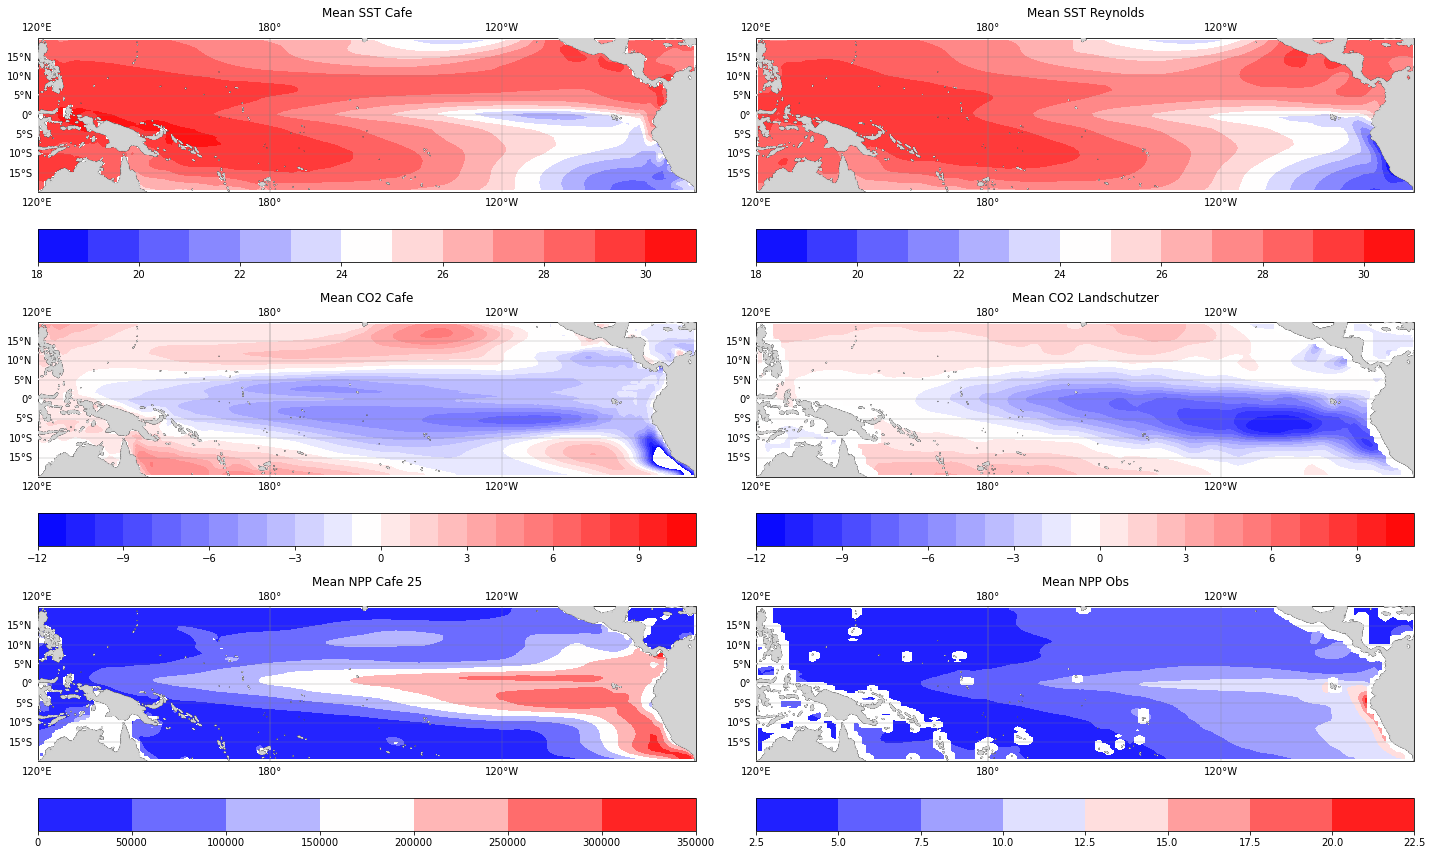

In [69]:
fig = plt.figure(figsize=(20,12))

plot_pacific_subplot(sst_cafe.sel(ensemble=25).mean(dim='time'),sb=321,title='Mean SST Cafe',levels=np.arange(18,32,1))
plot_pacific_subplot(sst_rey.mean(dim='time'),sb=322,title='Mean SST Reynolds',levels=np.arange(18,32,1))

plot_pacific_subplot(co2_cafe.sel(ensemble=25).mean(dim='time'),sb=323,title='Mean CO2 Cafe',levels=np.arange(-12,12,1))
plot_pacific_subplot(co2_land.mean(dim='time'),sb=324,title='Mean CO2 Landschutzer',levels=np.arange(-12,12,1))
#plot_pacific_subplot(co2_rodenbeck.mean(dim='time')*-1)
plot_pacific_subplot(npp_cafe_25.mean(dim='time'),sb=325,title='Mean NPP Cafe 25')
#plot_pacific_subplot(npp_cafe_23.mean(dim='time'),sb=326,title='NPP Cafe 25')
plot_pacific_subplot(np_dat.mean(dim='time'),sb=326,title='Mean NPP Obs')
plt.tight_layout()
plt.show()

## Figure 2: Trends

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stat = xr.apply_ufunc(lin_xarray_linregress, x,y,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:68: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be remov

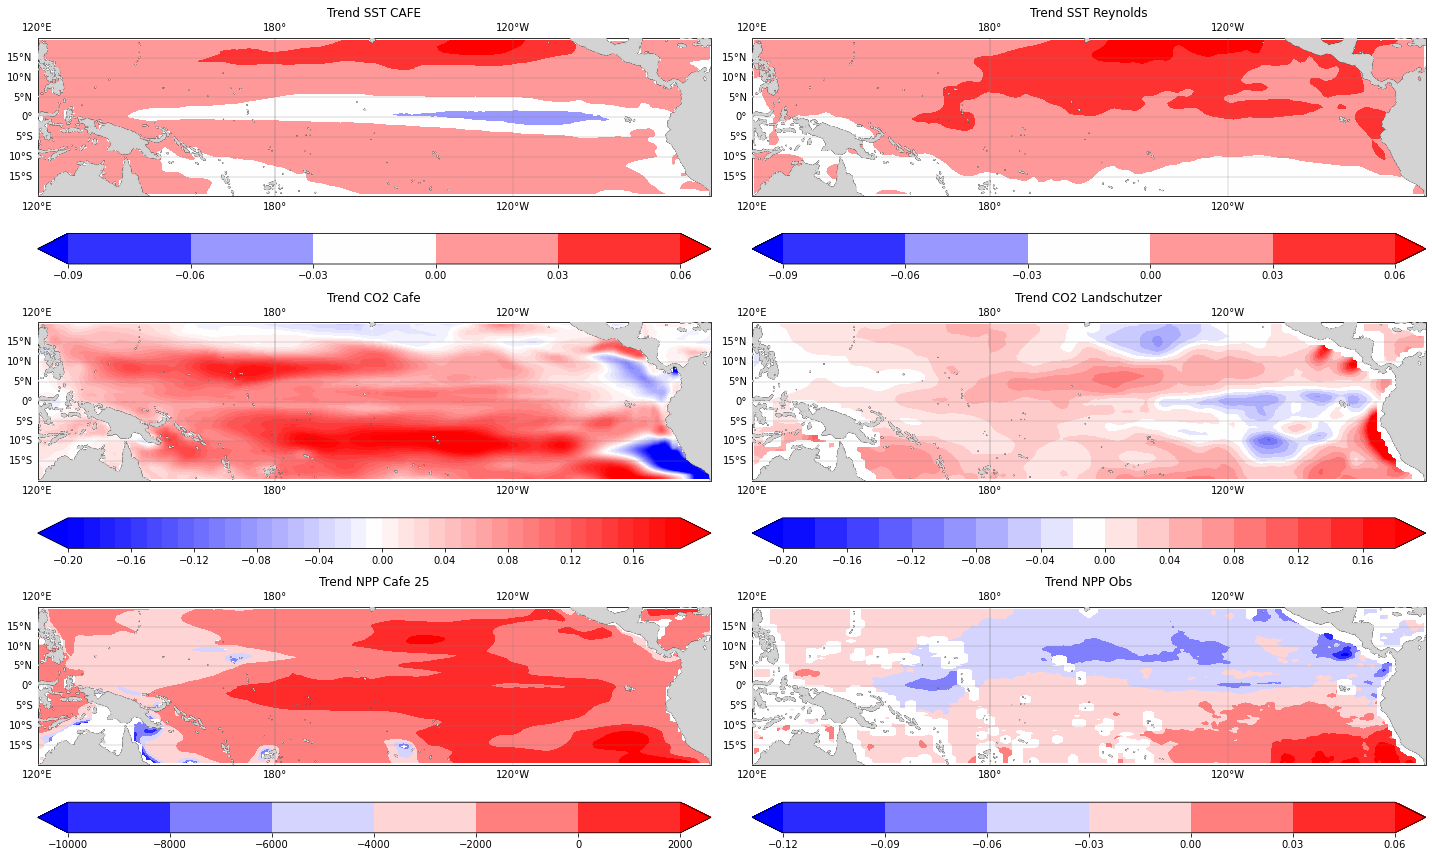

In [95]:
fig = plt.figure(figsize=(20,12))

plot_pacific_subplot(xarray_get_trend(sst_cafe.sel(ensemble=25)).sel(parameter=0)*365,sb=321,title='Trend SST CAFE',levels=np.arange(-0.09,0.09,0.03))
plot_pacific_subplot(xarray_get_trend(sst_rey).sel(parameter=0)*365,sb=322,title='Trend SST Reynolds',levels=np.arange(-0.09,0.09,0.03))#,levels=np.arange(18,32,1))

plot_pacific_subplot(xarray_get_trend(co2_cafe.sel(ensemble=25)).sel(parameter=0)*365,sb=323,title='Trend CO2 Cafe',levels=np.arange(-0.2,0.2,0.01))
plot_pacific_subplot(xarray_get_trend(co2_land).sel(parameter=0)*365,sb=324,title='Trend CO2 Landschutzer',levels=np.arange(-0.2,0.2,0.02))
#plot_pacific_subplot(co2_rodenbeck.mean(dim='time')*-1)
plot_pacific_subplot(xarray_get_trend(npp_cafe_25).sel(parameter=0)*365,sb=325,title='Trend NPP Cafe 25')
#plot_pacific_subplot(npp_cafe_23.mean(dim='time'),sb=326,title='NPP Cafe 25')
plot_pacific_subplot(xarray_get_trend(np_dat).sel(parameter=0)*365,sb=326,title='Trend NPP Obs')
plt.tight_layout()
plt.show()

# Figure 3: Seasonal Magnitude

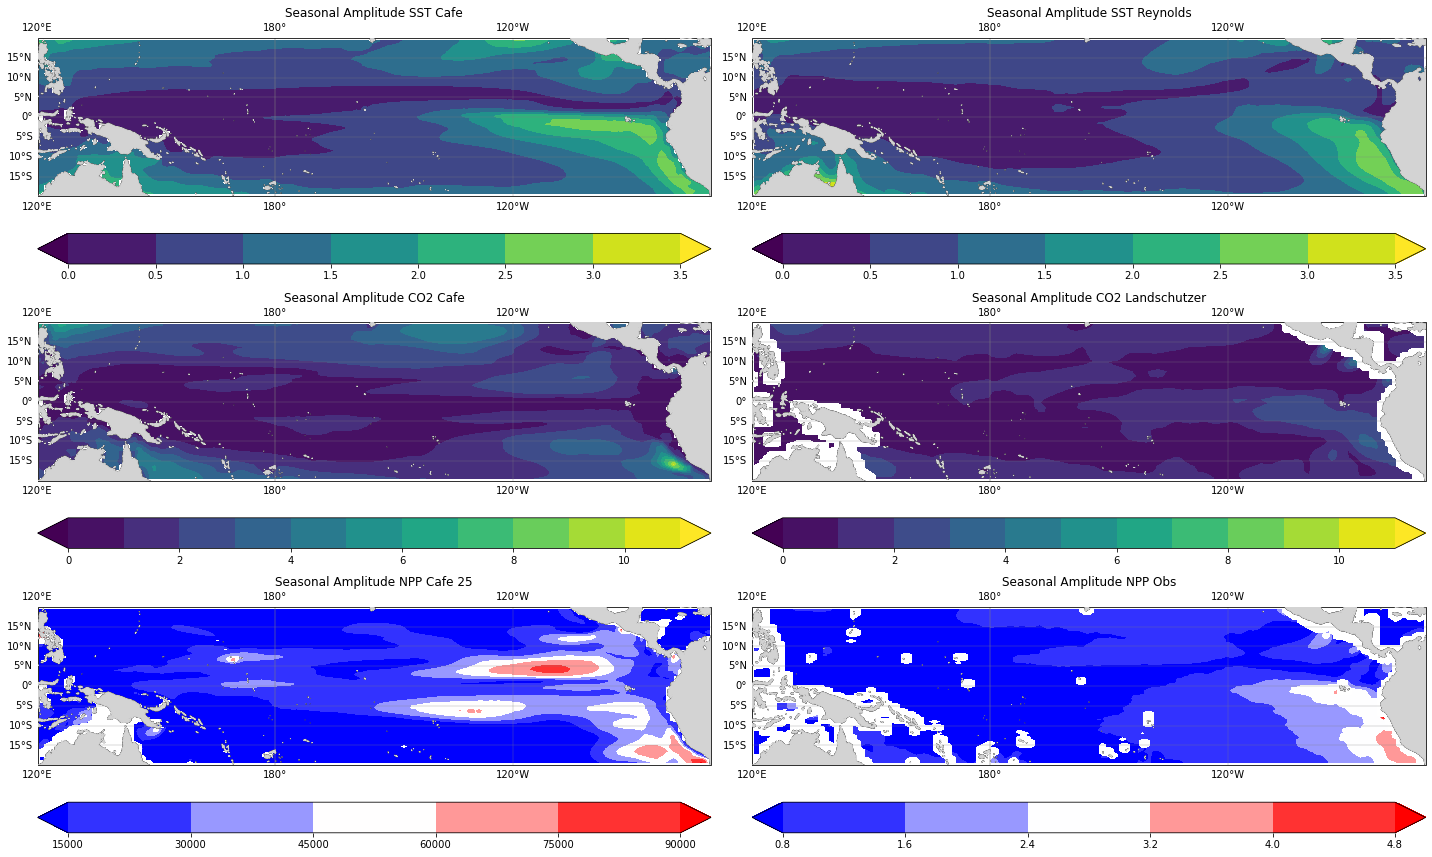

In [94]:
fig = plt.figure(figsize=(20,12))

plot_pacific_subplot(sst_cafe.sel(ensemble=25).groupby('time.month').mean().std(dim='month'),sb=321,title='Seasonal Amplitude SST Cafe',cmap='viridis',levels=np.arange(0,4,0.5))
plot_pacific_subplot(sst_rey.groupby('time.month').mean().std(dim='month'),sb=322,title='Seasonal Amplitude SST Reynolds',cmap='viridis',levels=np.arange(0,4,0.5))

plot_pacific_subplot(co2_cafe.sel(ensemble=25).groupby('time.month').mean().std(dim='month'),sb=323,title='Seasonal Amplitude CO2 Cafe',cmap='viridis',levels=np.arange(0,12,1))#,levels=np.arange(-12,12,1))
plot_pacific_subplot(co2_land.groupby('time.month').mean().std(dim='month'),sb=324,title='Seasonal Amplitude CO2 Landschutzer',cmap='viridis',levels=np.arange(0,12,1))#,levels=np.arange(-12,12,1))
#plot_pacific_subplot(co2_rodenbeck.mean(dim='time')*-1)
plot_pacific_subplot(npp_cafe_25.groupby('time.month').mean().std(dim='month'),sb=325,title='Seasonal Amplitude NPP Cafe 25')
#plot_pacific_subplot(npp_cafe_23.mean(dim='time'),sb=326,title='NPP Cafe 25')
plot_pacific_subplot(np_dat.groupby('time.month').mean().std(dim='month'),sb=326,title='Seasonal Amplitude NPP Obs')
plt.tight_layout()
plt.show()

# Figure 3b: Seasonal Magnitude / Peak Month

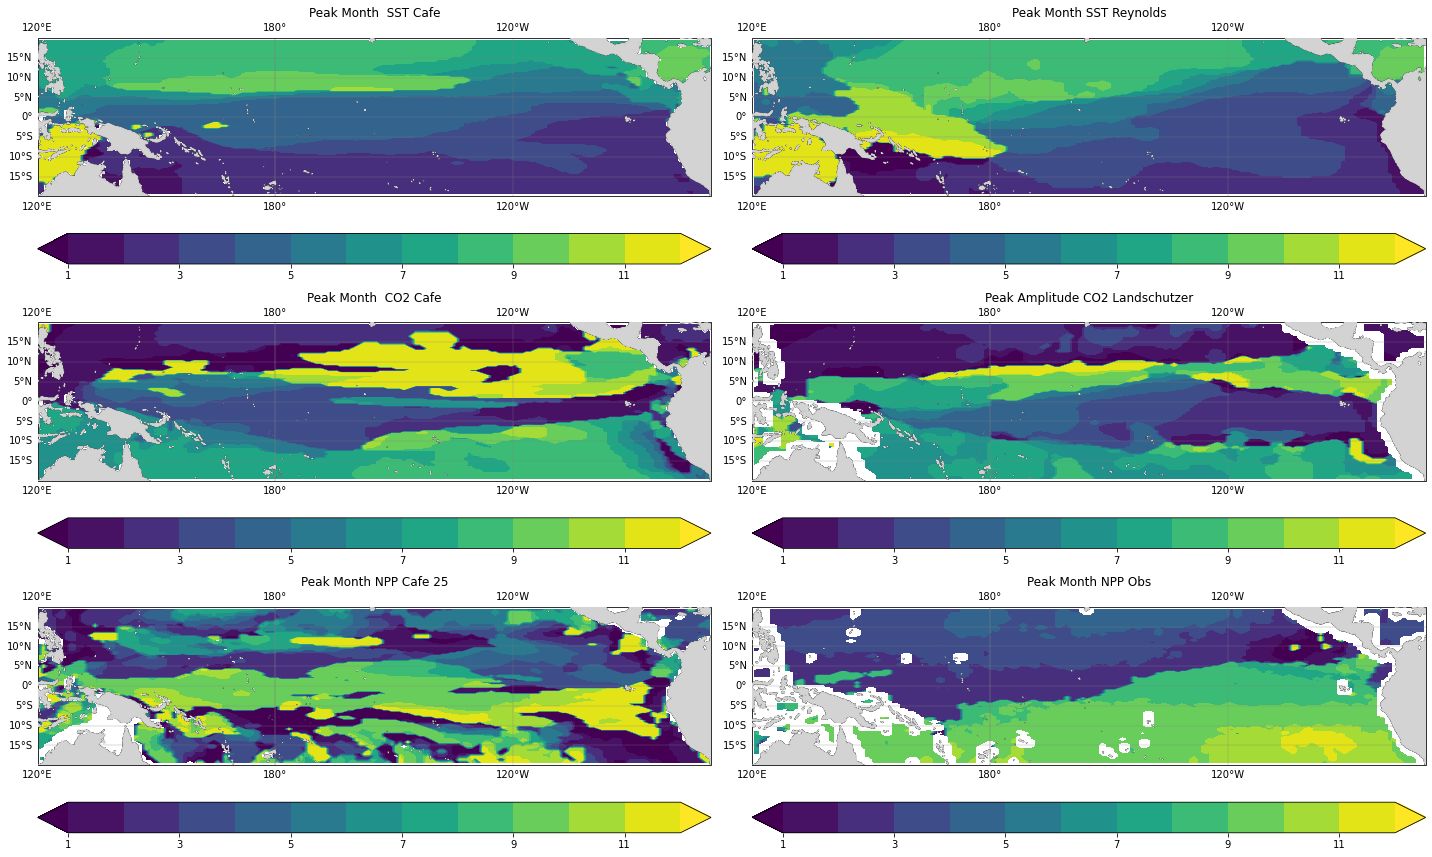

In [112]:
fig = plt.figure(figsize=(20,12))

plot_pacific_subplot(sst_cafe.sel(ensemble=25).groupby('time.month').mean().idxmax(dim='month'),sb=321,title='Peak Month  SST Cafe',cmap='viridis',levels=np.arange(1,13,1),extend='neither')
plot_pacific_subplot(sst_rey.groupby('time.month').mean().idxmax(dim='month'),sb=322,title='Peak Month SST Reynolds',cmap='viridis',levels=np.arange(1,13,1),extend='neither')

plot_pacific_subplot(co2_cafe.sel(ensemble=25).groupby('time.month').mean().idxmax(dim='month'),sb=323,title='Peak Month  CO2 Cafe',cmap='viridis',levels=np.arange(1,13,1),extend='neither')#,levels=np.arange(-12,12,1))
plot_pacific_subplot(co2_land.groupby('time.month').mean().idxmax(dim='month'),sb=324,title='Peak Amplitude CO2 Landschutzer',cmap='viridis',levels=np.arange(1,13,1),extend='neither')#,levels=np.arange(-12,12,1))
#plot_pacific_subplot(co2_rodenbeck.mean(dim='time')*-1)
plot_pacific_subplot(npp_cafe_25.groupby('time.month').mean().idxmax(dim='month'),sb=325,title='Peak Month NPP Cafe 25',cmap='viridis',levels=np.arange(1,13,1),extend='neither')
#plot_pacific_subplot(npp_cafe_23.mean(dim='time'),sb=326,title='NPP Cafe 25')
plot_pacific_subplot(np_dat.groupby('time.month').mean().idxmax(dim='month'),sb=326,title='Peak Month NPP Obs',cmap='viridis',levels=np.arange(1,13,1),extend='neither')
plt.tight_layout()
plt.show()

In [79]:
#plot_pacific(sst_rey.mean(dim='time'))
#plot_pacific(sst_cafe.sel(ensemble=25).groupby('time.month').mean().std(dim='month'))
#plot_pacific(sst_rey.groupby('time.month').mean().std(dim='month'))
#plot_pacific(co2_cafe.sel(ensemble=25).groupby('time.month').mean().std(dim='month'))
#plot_pacific(co2_land.groupby('time.month').mean().std(dim='month'))
#plot_pacific((co2_rodenbeck*-1).groupby('time.month').mean().std(dim='month'))
#plot_pacific(npp_cafe_25.groupby('time.month').mean().std(dim='month'))
#plot_pacific(npp_cafe_23.groupby('time.month').mean().std(dim='month'))
#plot_pacific(np_dat.groupby('time.month').mean().std(dim='month'))

In [35]:
# Figure 4 should be 3 whole eqpac plots like seen below.  but One for each 

In [36]:
sst_cafe

<xarray.DataArray 'sst' (time: 240, ensemble: 96, lat: 98, lon: 170)>
[383846400 values with dtype=float32]
Coordinates:
  * ensemble  (ensemble) int32 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * time      (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36
    st_ocean  float64 105.0

# Figure 4: Detrended, Deseasonalised Interannual variability

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_tr

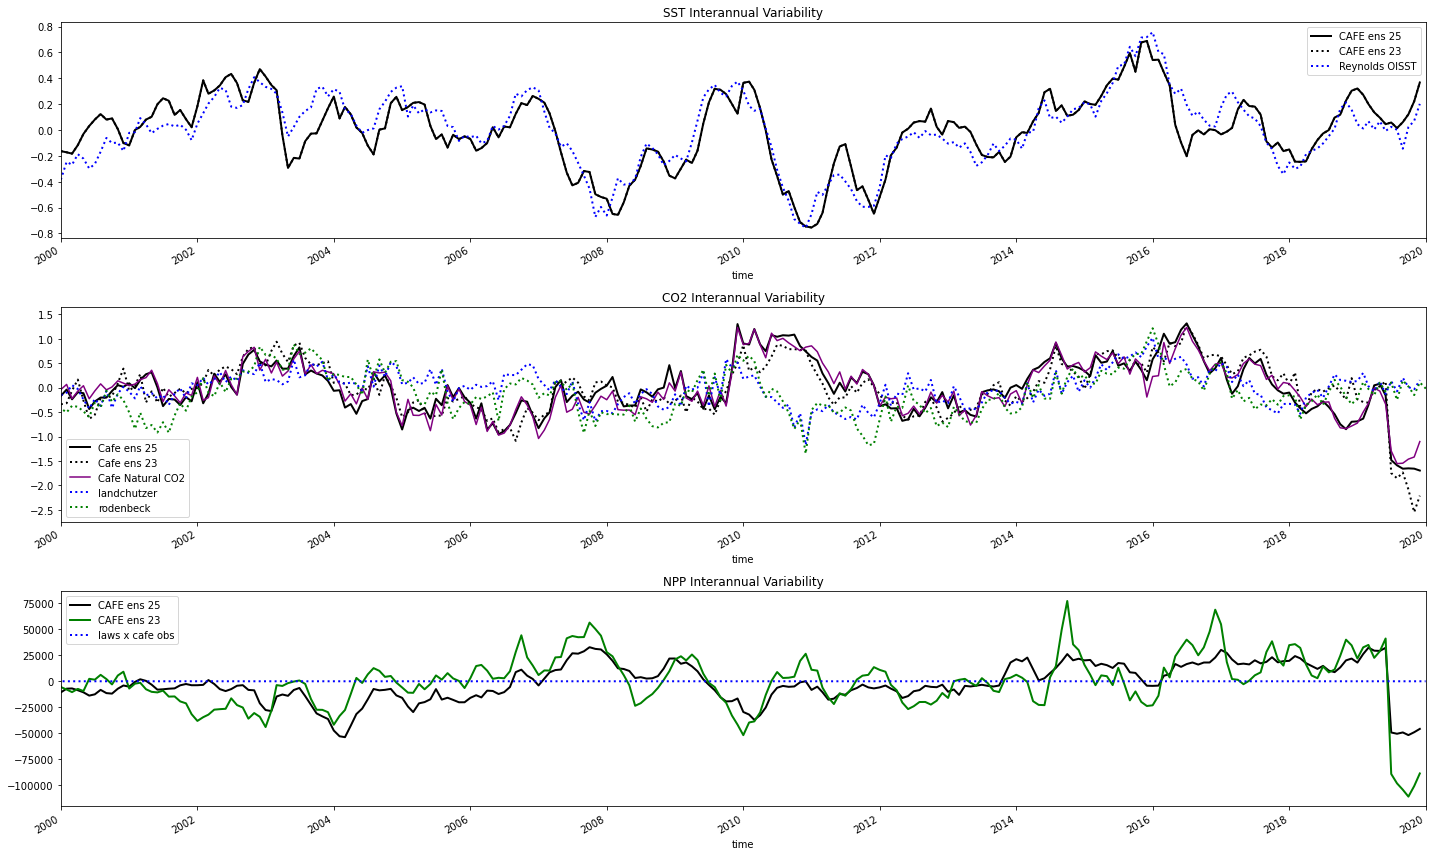

In [126]:
plt.figure(figsize=(20,12))
plt.subplot(311)
deseasonaliser(xarray_detrend(sst_cafe.sel(ensemble=25),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
deseasonaliser(xarray_detrend(sst_cafe.sel(ensemble=25),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2,linestyle=':')
deseasonaliser(xarray_detrend(sst_rey,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE ens 25','CAFE ens 23','Reynolds OISST'])
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('SST Interannual Variability')

plt.subplot(312)
deseasonaliser(xarray_detrend(co2_cafe.sel(ensemble=25),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
deseasonaliser(xarray_detrend(co2_cafe.sel(ensemble=23),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2,linestyle=':')
deseasonaliser(xarray_detrend(co2_cafe_natural.sel(ensemble=25),keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='purple')
deseasonaliser(xarray_detrend(co2_land,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
deseasonaliser(xarray_detrend(co2_rodenbeck*-1,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='g',linewidth=2,linestyle=':')
plt.legend(['Cafe ens 25','Cafe ens 23','Cafe Natural CO2','landchutzer','rodenbeck'])
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('CO2 Interannual Variability')

plt.subplot(313)
deseasonaliser(xarray_detrend(npp_cafe_25,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
deseasonaliser(xarray_detrend(npp_cafe_23,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='g',linewidth=2)
deseasonaliser(xarray_detrend(np_dat,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
plt.legend(['CAFE ens 25','CAFE ens 23','laws x cafe obs'])
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])
plt.title('NPP Interannual Variability')
plt.tight_layout()

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:39: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,return_trend,


(10957.0, 18262.0)

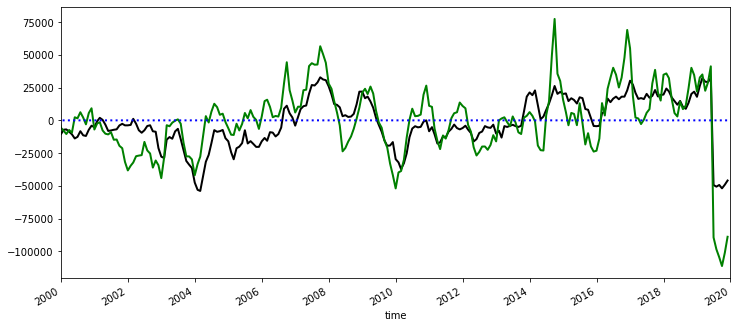

In [119]:
plt.figure(figsize=(12,5))
deseasonaliser(xarray_detrend(npp_cafe_25,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='k',linewidth=2)
deseasonaliser(xarray_detrend(npp_cafe_23,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='g',linewidth=2)
deseasonaliser(xarray_detrend(np_dat,keep_intercept_values=False)).mean(dim=['lat','lon']).plot(c='b',linewidth=2,linestyle=':')
plt.xlim([np.datetime64('2000-01-01'),np.datetime64('2020-01-01')])

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:38: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:38: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/xarray_trends.py:38: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


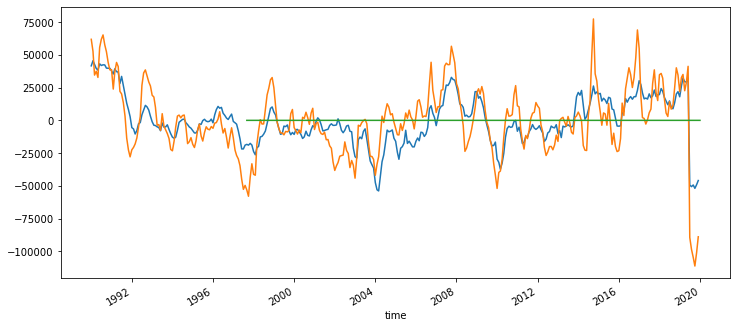

In [58]:
plt.figure(figsize=(12,5))
deseasonaliser(xarray_detrend(npp_cafe_25,keep_intercept_values=False)).mean(dim=['lat','lon']).plot()
deseasonaliser(xarray_detrend(npp_cafe_23,keep_intercept_values=False)).mean(dim=['lat','lon']).plot()
deseasonaliser(xarray_detrend(np_dat,keep_intercept_values=False)).mean(dim=['lat','lon']).plot()
#deseasonaliser(xarray_detrend(sst_rey,keep_intercept_values=False)).mean(dim=['lat','lon']).plot()

In [44]:
[-15,15,150,275]

In [44]:
# Convert Data for plotting
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('2000-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))
co2_cafe=bgcdatvs_allens.stf10.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
co2_land=land_co2.sel(time=slice('1990-01-01','2020-01-01'))

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


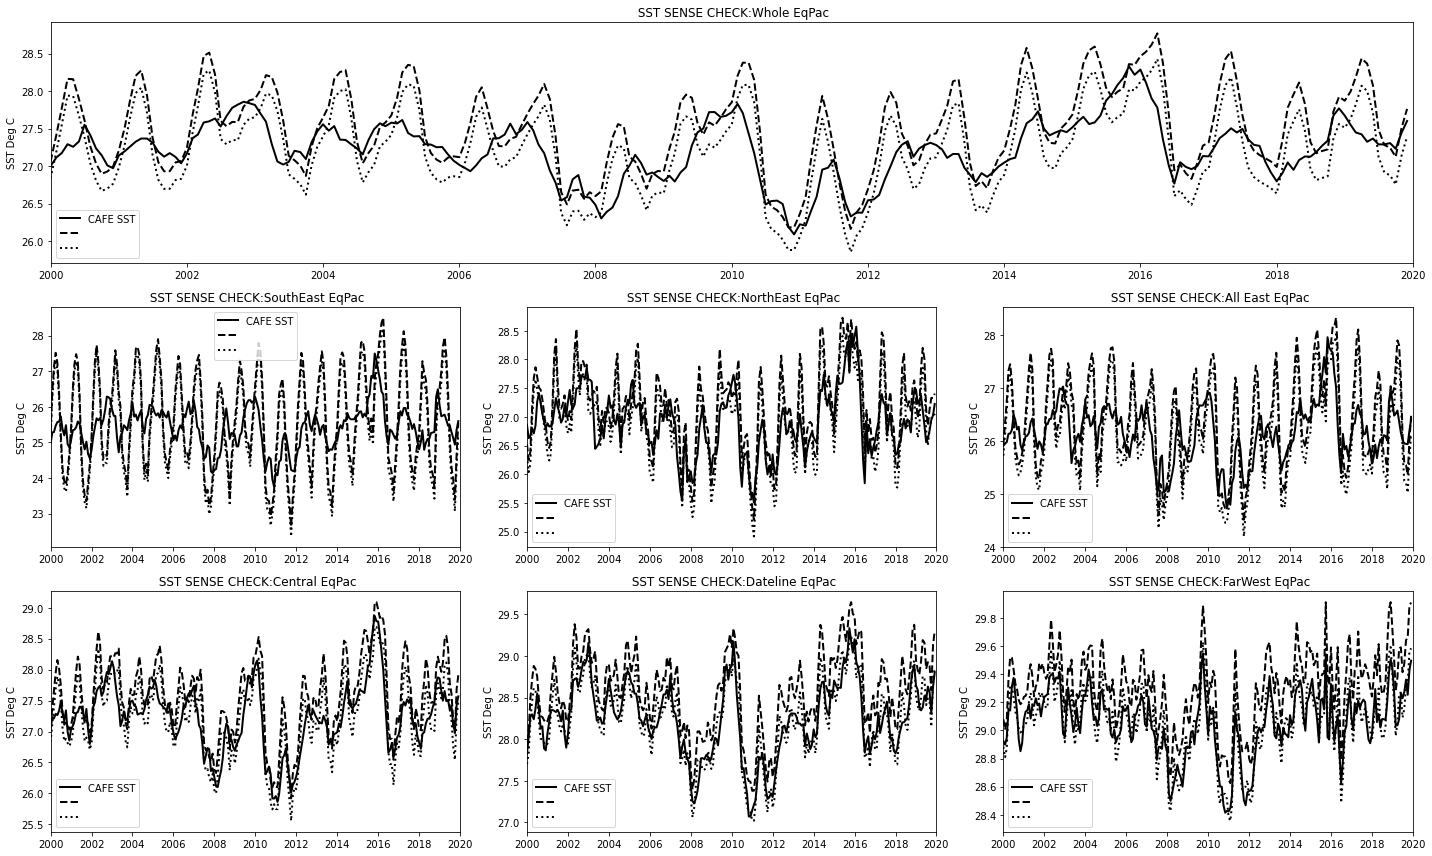

In [45]:
# Good test case
plot_pacific_boxes(var_a=sst_cafe,
                   var_b=None,
                   var_a_name='CAFE SST',
                   var_b_name=None,
                   units='SST Deg C',
                   title=' SST SENSE CHECK:',sdate='2000-01-01',
                   detrend=True,deseasonalise=True,plot_decomposition=True,keep_intercept_values=True)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


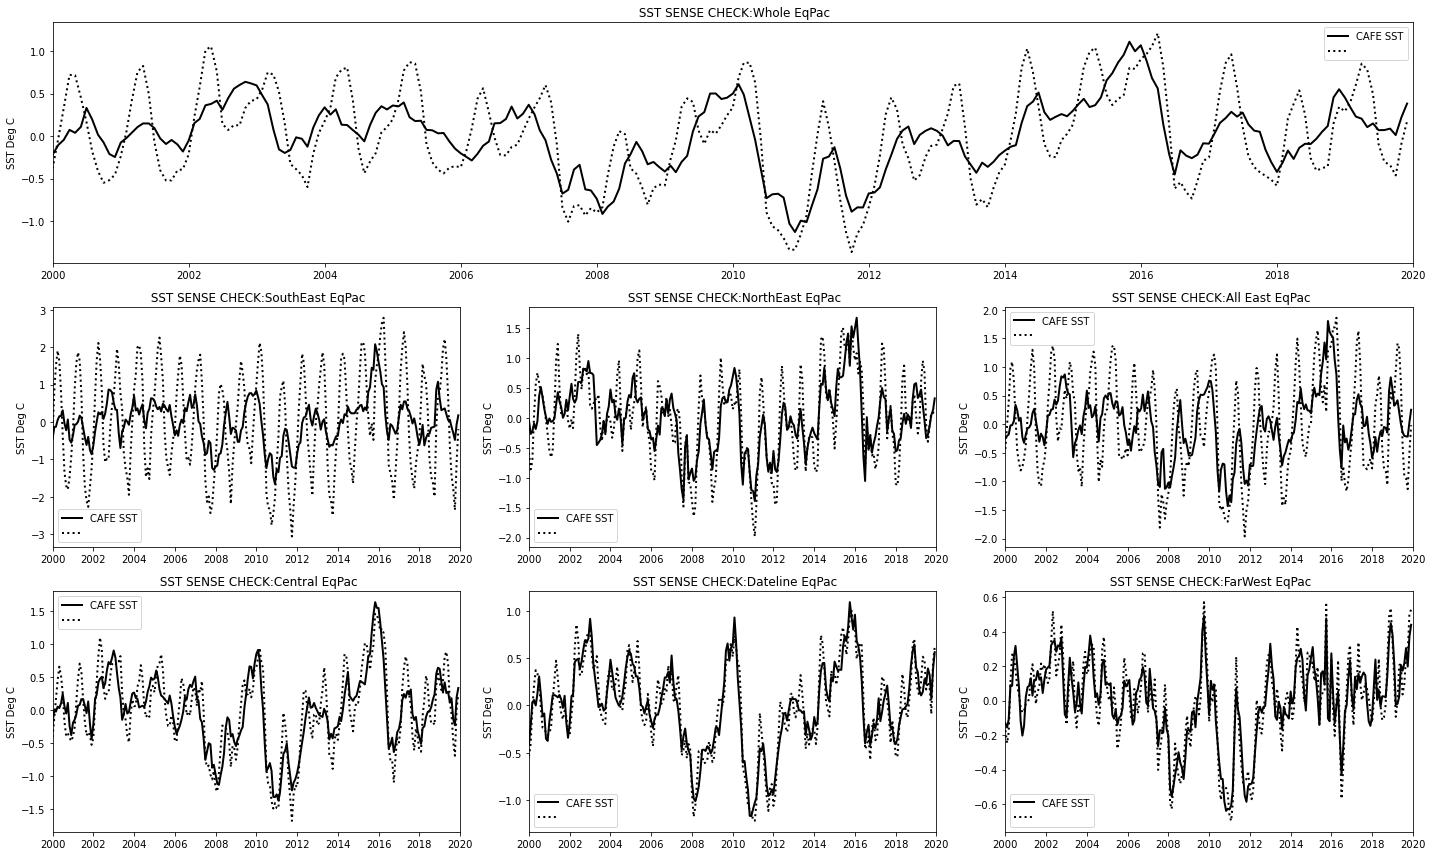

In [46]:
# Good test case
plot_pacific_boxes(var_a=sst_cafe,
                   var_b=None,
                   var_a_name='CAFE SST',
                   var_b_name=None,
                   units='SST Deg C',
                   title=' SST SENSE CHECK:',sdate='2000-01-01',
                   detrend=True,deseasonalise=True,plot_decomposition=True,keep_intercept_values=False,rolling=False)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


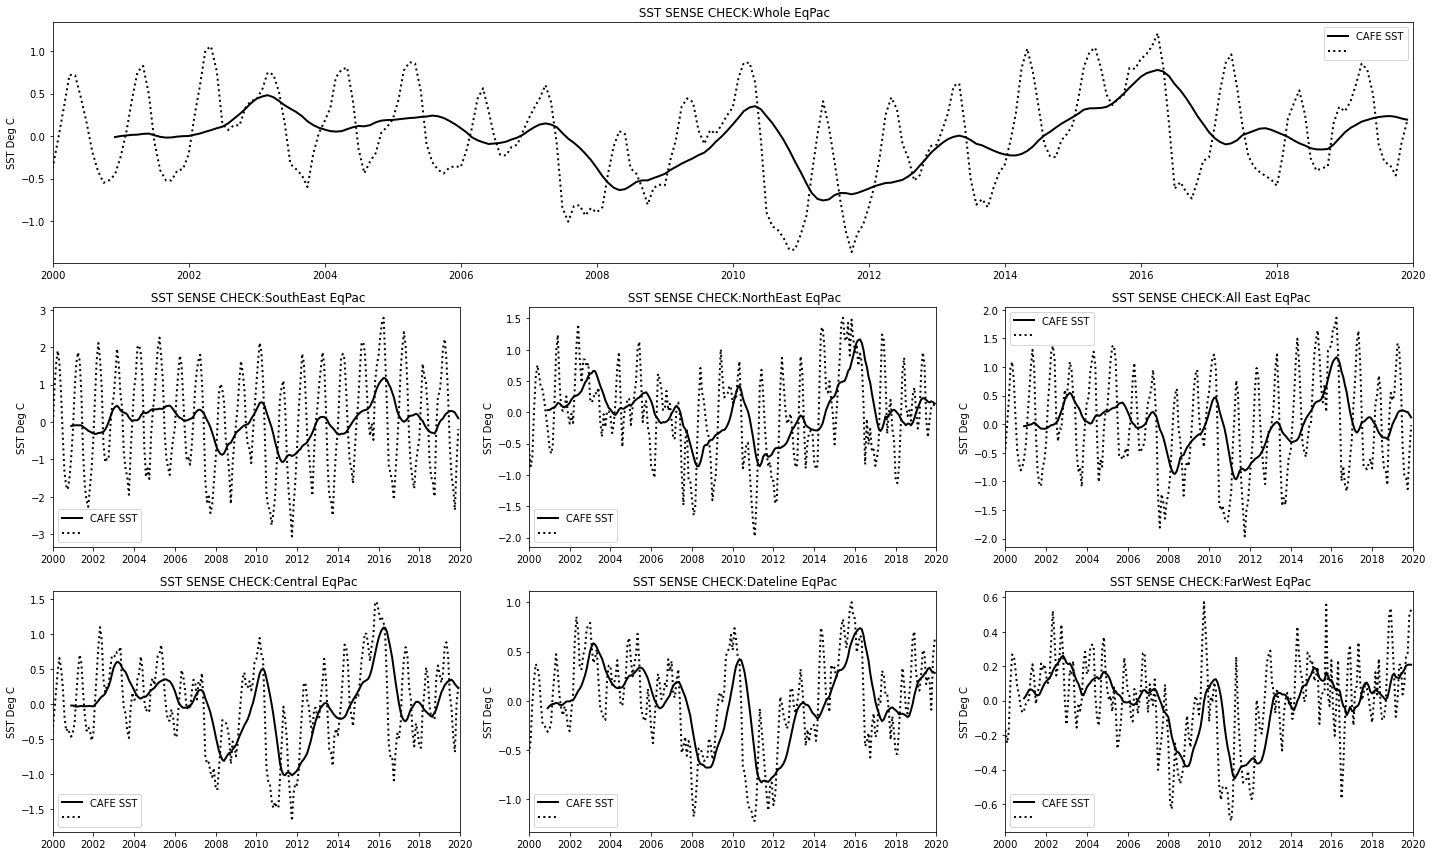

In [47]:
# Good test case
plot_pacific_boxes(var_a=sst_cafe,
                   var_b=None,
                   var_a_name='CAFE SST',
                   var_b_name=None,
                   units='SST Deg C',
                   title=' SST SENSE CHECK:',sdate='2000-01-01',
                   detrend=True,deseasonalise=True,plot_decomposition=True,keep_intercept_values=False,rolling=True)

In [48]:
rodenbeck_co2

<xarray.DataArray 'co2flux_ocean' (time: 768, lat: 98, lon: 170)>
[12794880 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1957-01-01 1957-02-01 ... 2020-12-01
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat      (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36

In [49]:
rodenbeck1_CO2=xr.open_dataset('../../rxm599/obs/oc_v2021_daily.nc')

In [50]:
#rodenbeck1_CO2

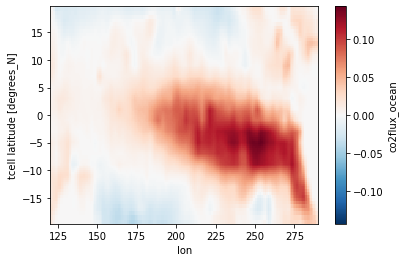

In [51]:
rodenbeck_co2.mean(dim='time').plot()

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


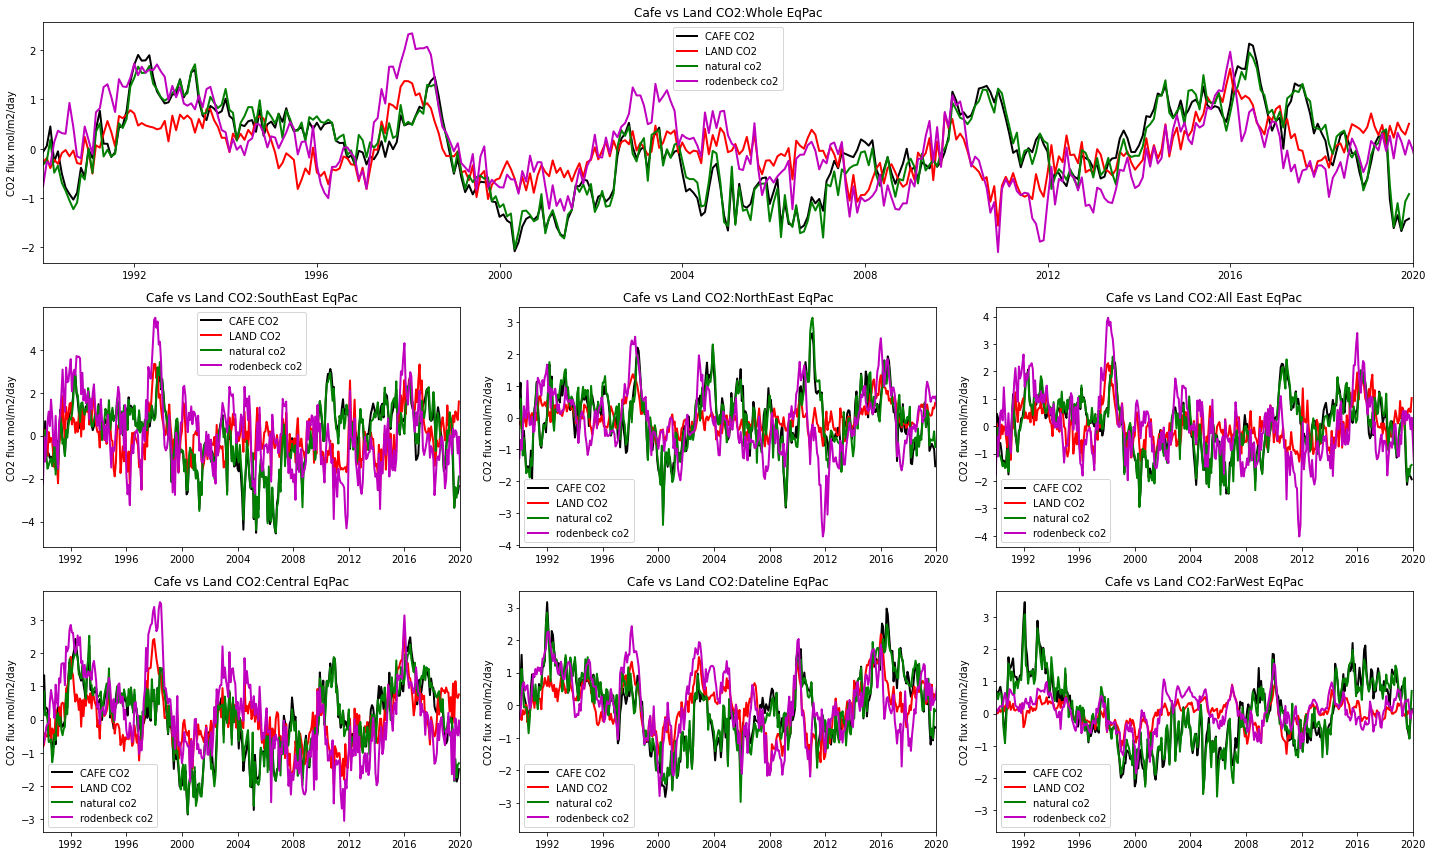

In [52]:
plot_pacific_boxes(var_a=bgcdatvs_allens.stf10.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=co2_land,
                   var_c=bgcdatvs_allens.stf07.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01')),
                   var_d=(rodenbeck_co2*-1000)/12,
                   var_a_name='CAFE CO2',
                   var_b_name='LAND CO2',
                   var_c_name='natural co2',
                   var_d_name='rodenbeck co2',
                   units='CO2 flux mol/m2/day',
                   title='Cafe vs Land CO2:',detrend=True,deseasonalise=True,keep_intercept_values=False)

In [53]:
co2_cafe=bgcdatvs_allens.stf10.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
co2_land=land_co2.sel(time=slice('1990-01-01','2020-01-01'))

0
1
2
3
4
5
6


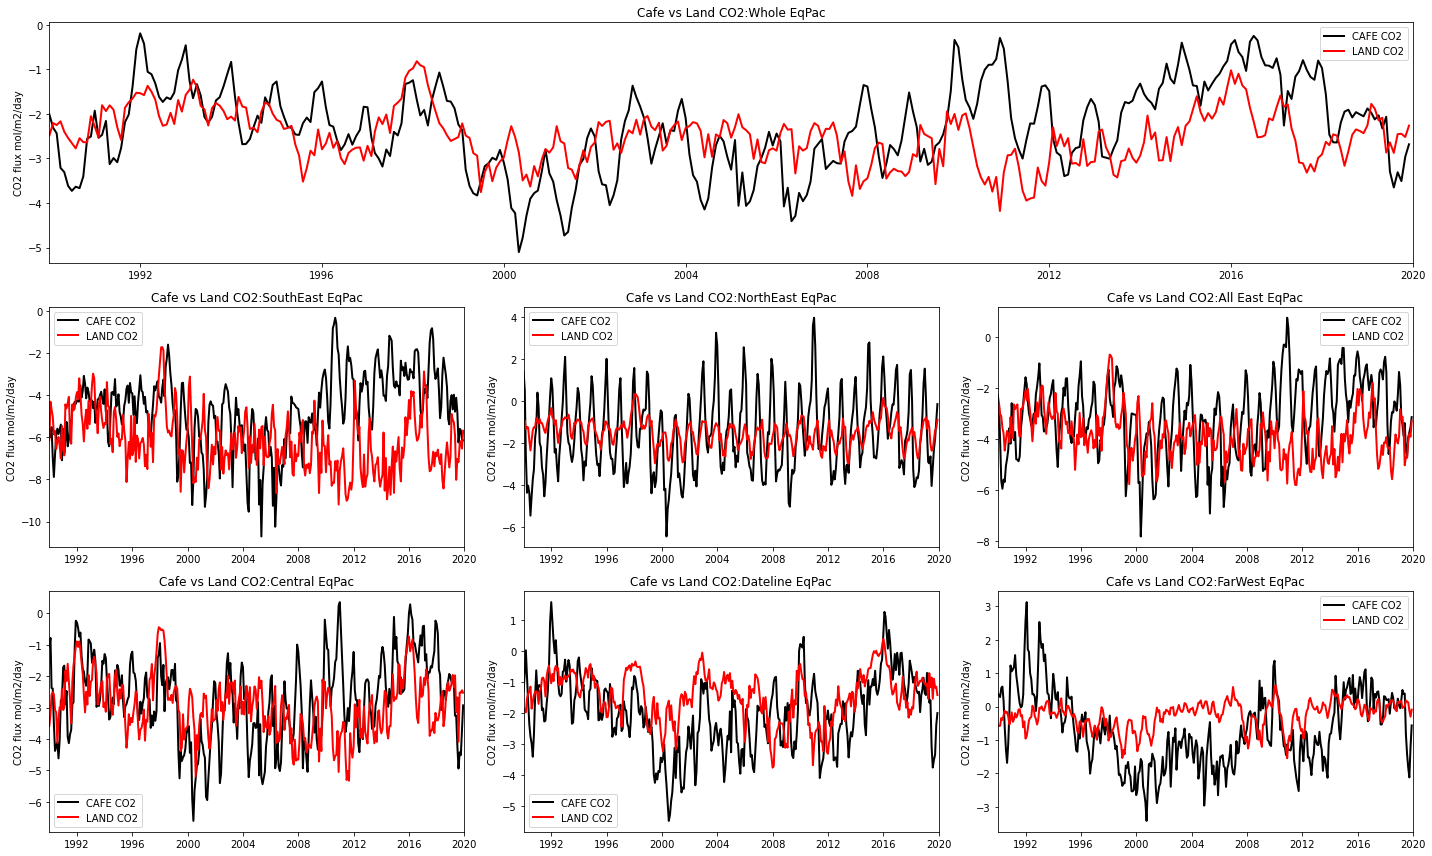

In [54]:
plot_pacific_boxes(var_a=co2_cafe,
                   var_b=co2_land,
                   var_a_name='CAFE CO2',
                   var_b_name='LAND CO2',
                   units='CO2 flux mol/m2/day',
                   title='Cafe vs Land CO2:',keep_intercept_values=False)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


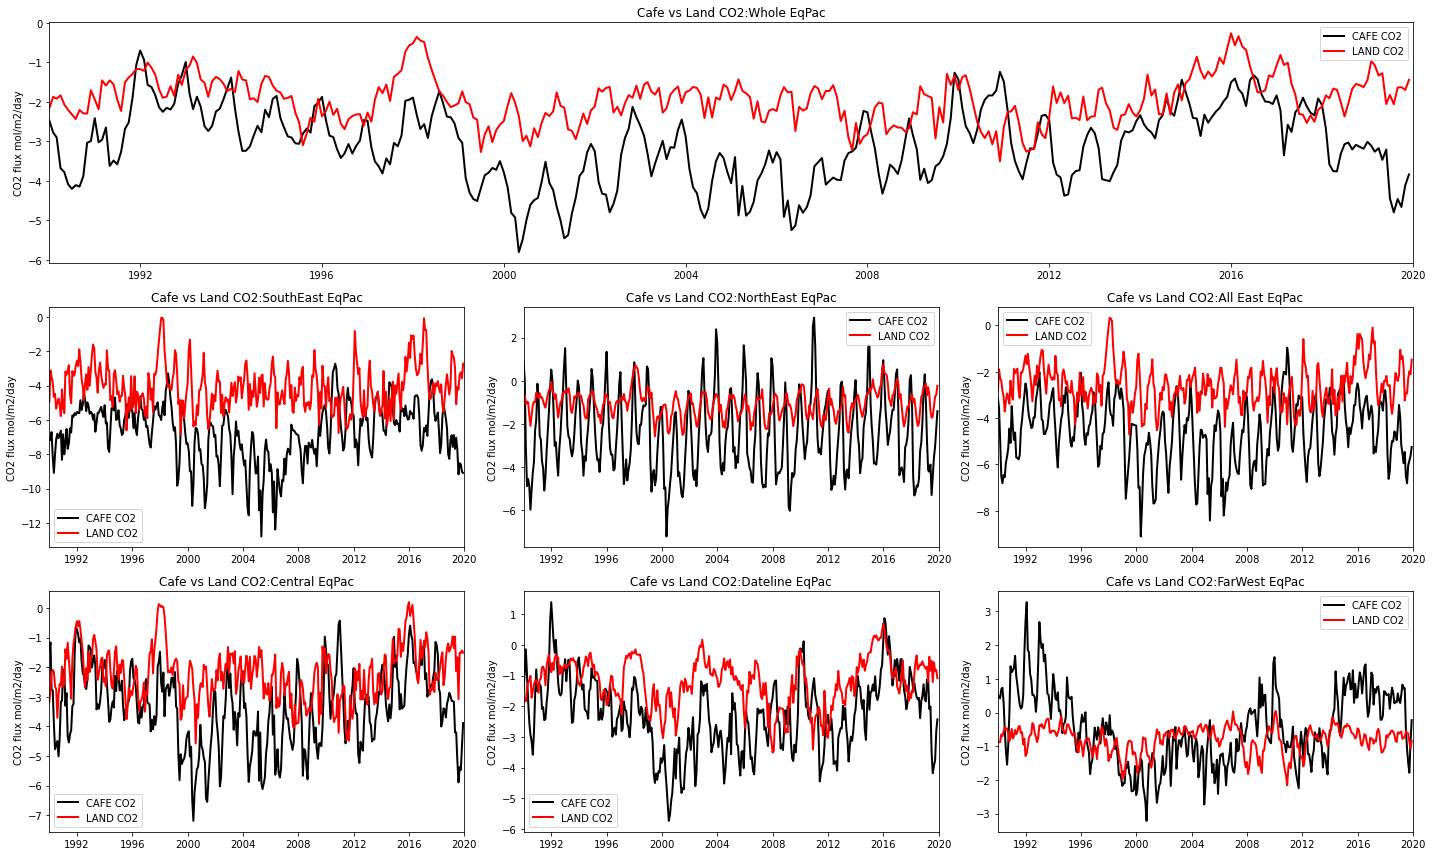

In [55]:
plot_pacific_boxes(var_a=co2_cafe,
                   var_b=co2_land,
                   var_a_name='CAFE CO2',
                   var_b_name='LAND CO2',
                   units='CO2 flux mol/m2/day',
                   title='Cafe vs Land CO2:',detrend=True)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


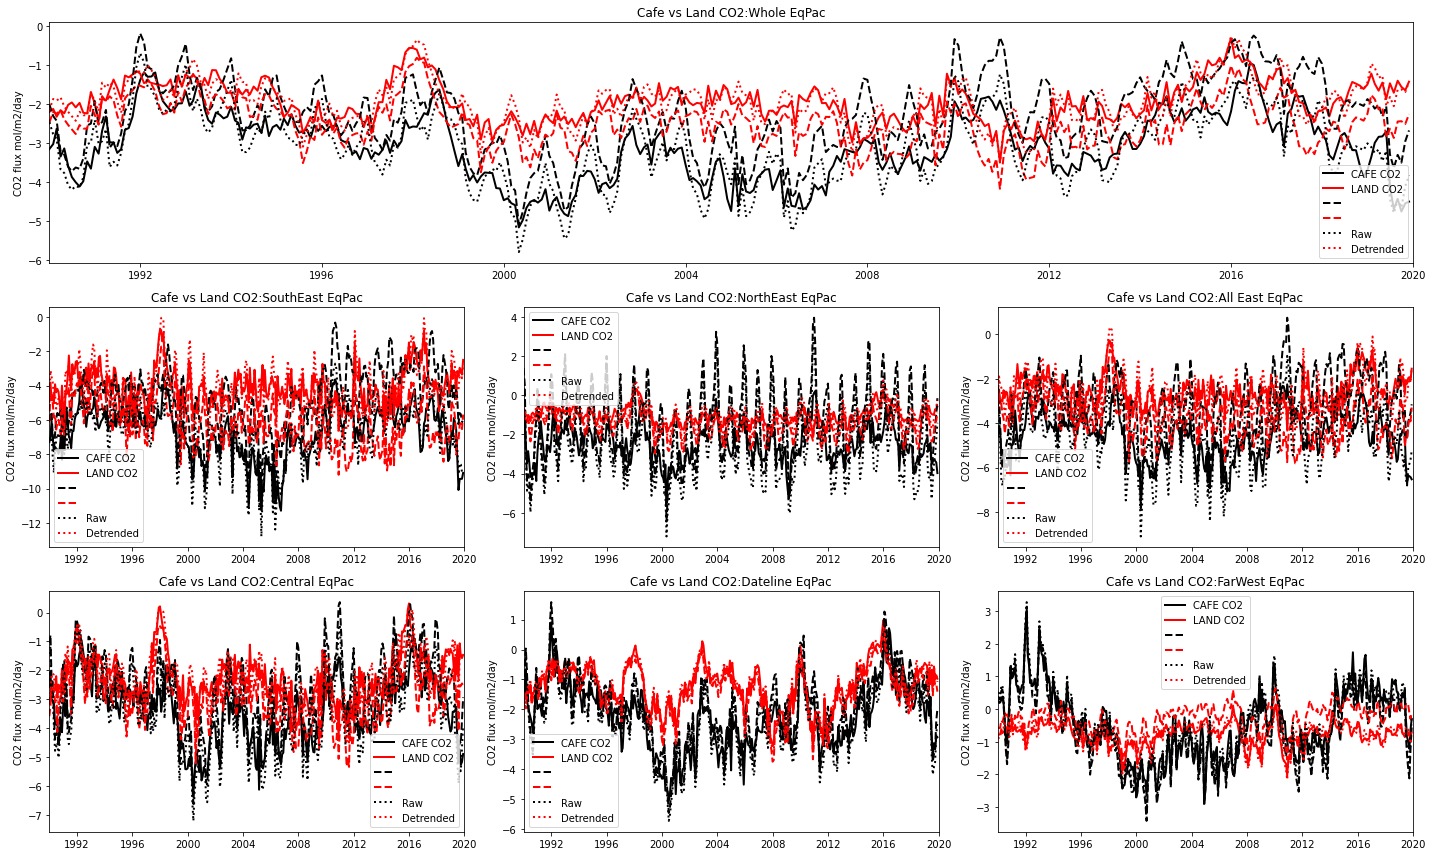

In [56]:
plot_pacific_boxes(var_a=co2_cafe,
                   var_b=co2_land,
                   var_a_name='CAFE CO2',
                   var_b_name='LAND CO2',
                   units='CO2 flux mol/m2/day',
                   title='Cafe vs Land CO2:',detrend=True,deseasonalise=True,plot_decomposition=True)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


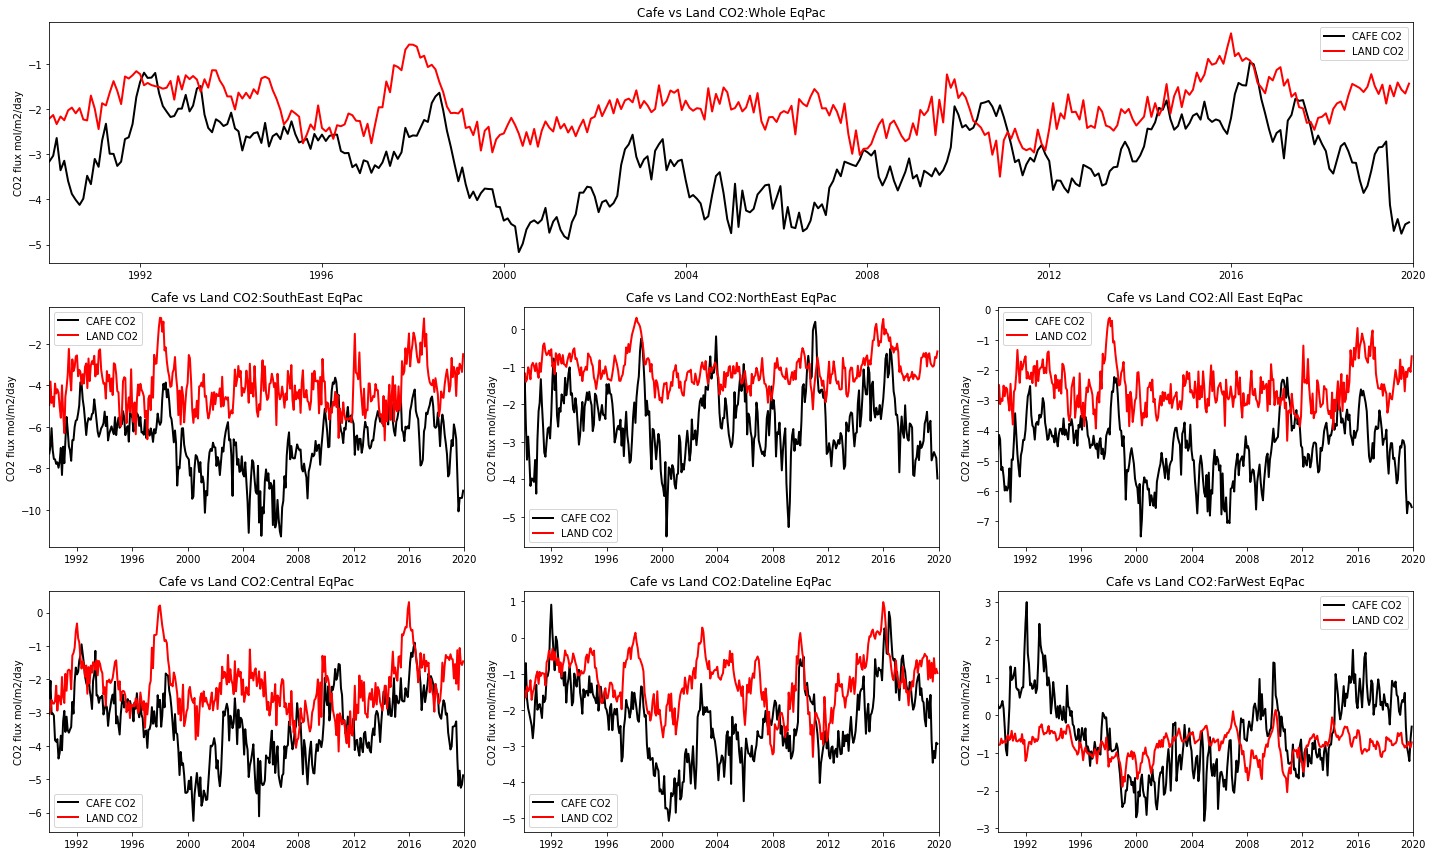

In [57]:
plot_pacific_boxes(var_a=co2_cafe,
                   var_b=co2_land,
                   var_a_name='CAFE CO2',
                   var_b_name='LAND CO2',
                   units='CO2 flux mol/m2/day',
                   title='Cafe vs Land CO2:',
                   detrend=True,
                   deseasonalise=True)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


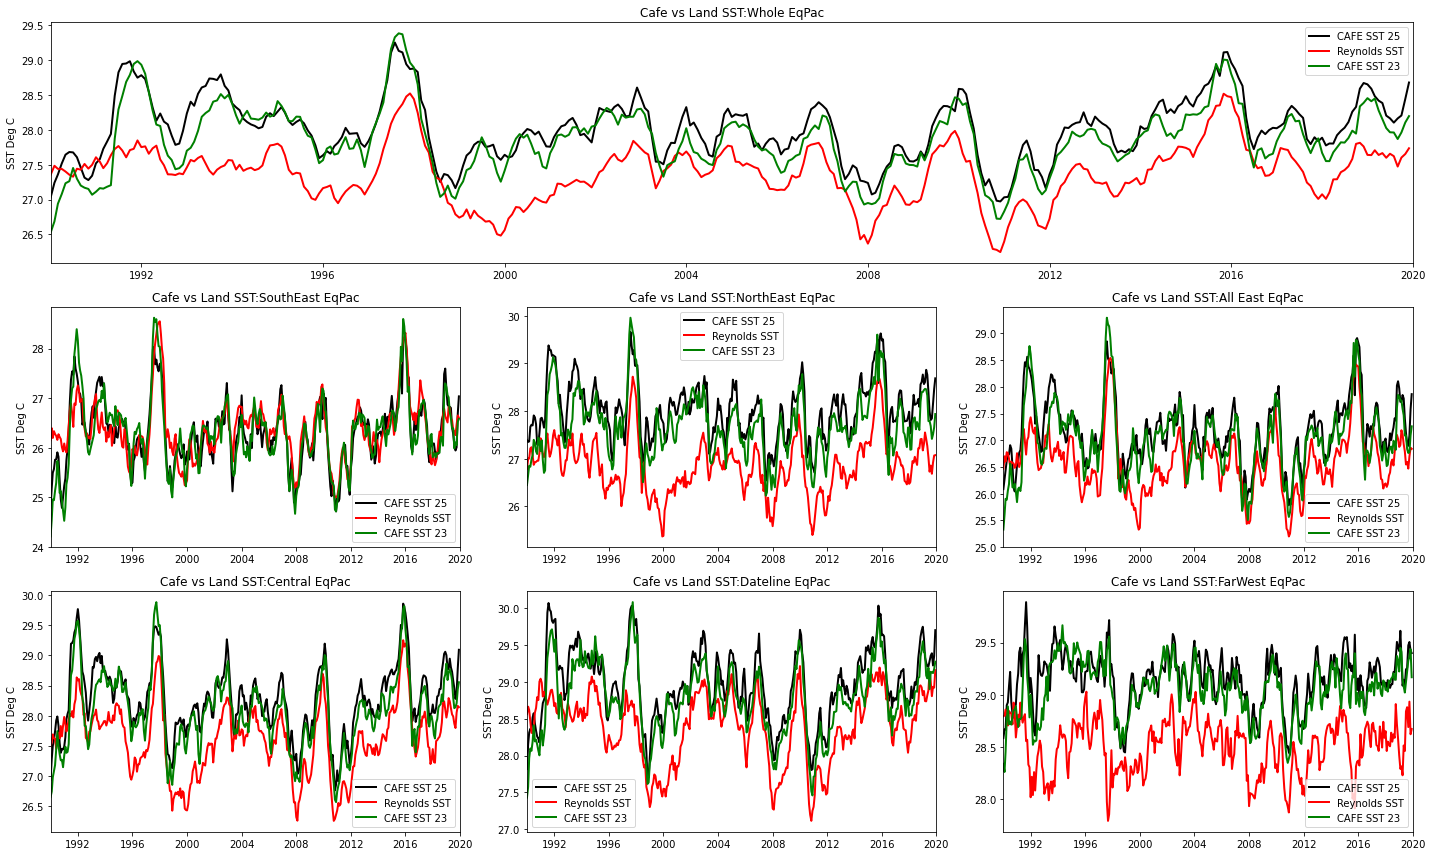

In [58]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.sst.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=sst_rey,
                   var_c=bgcdatvs_allens.sst.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE SST 25',
                   var_b_name='Reynolds SST',
                   var_c_name='CAFE SST 23',
                   units='SST Deg C',
                   title='Cafe vs Land SST:',
                   detrend=True,deseasonalise=True,keep_intercept_values=True)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


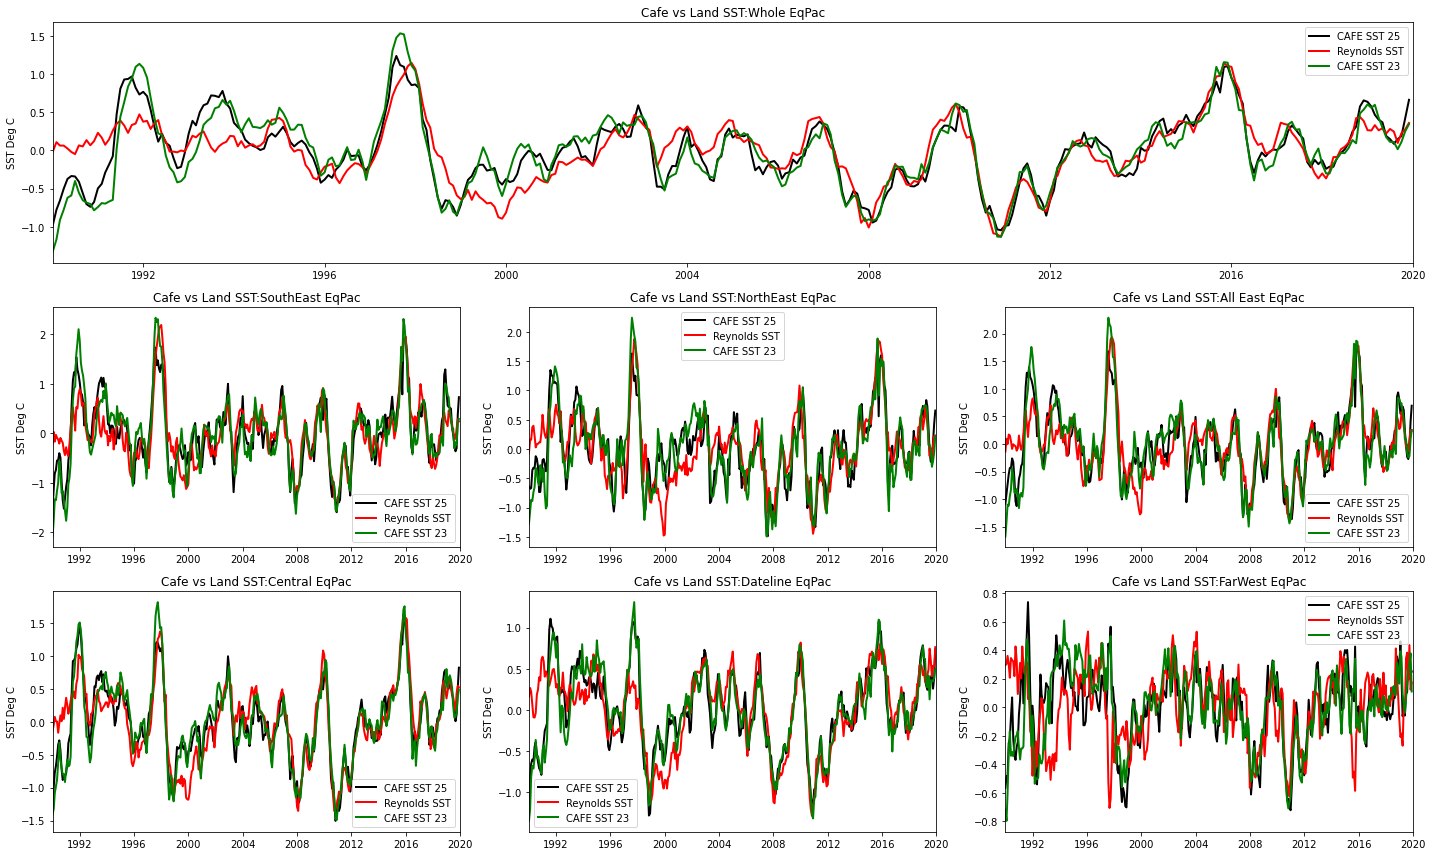

In [59]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.sst.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=sst_rey,
                   var_c=bgcdatvs_allens.sst.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE SST 25',
                   var_b_name='Reynolds SST',
                   var_c_name='CAFE SST 23',
                   units='SST Deg C',
                   title='Cafe vs Land SST:',
                   detrend=True,deseasonalise=True,keep_intercept_values=False)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


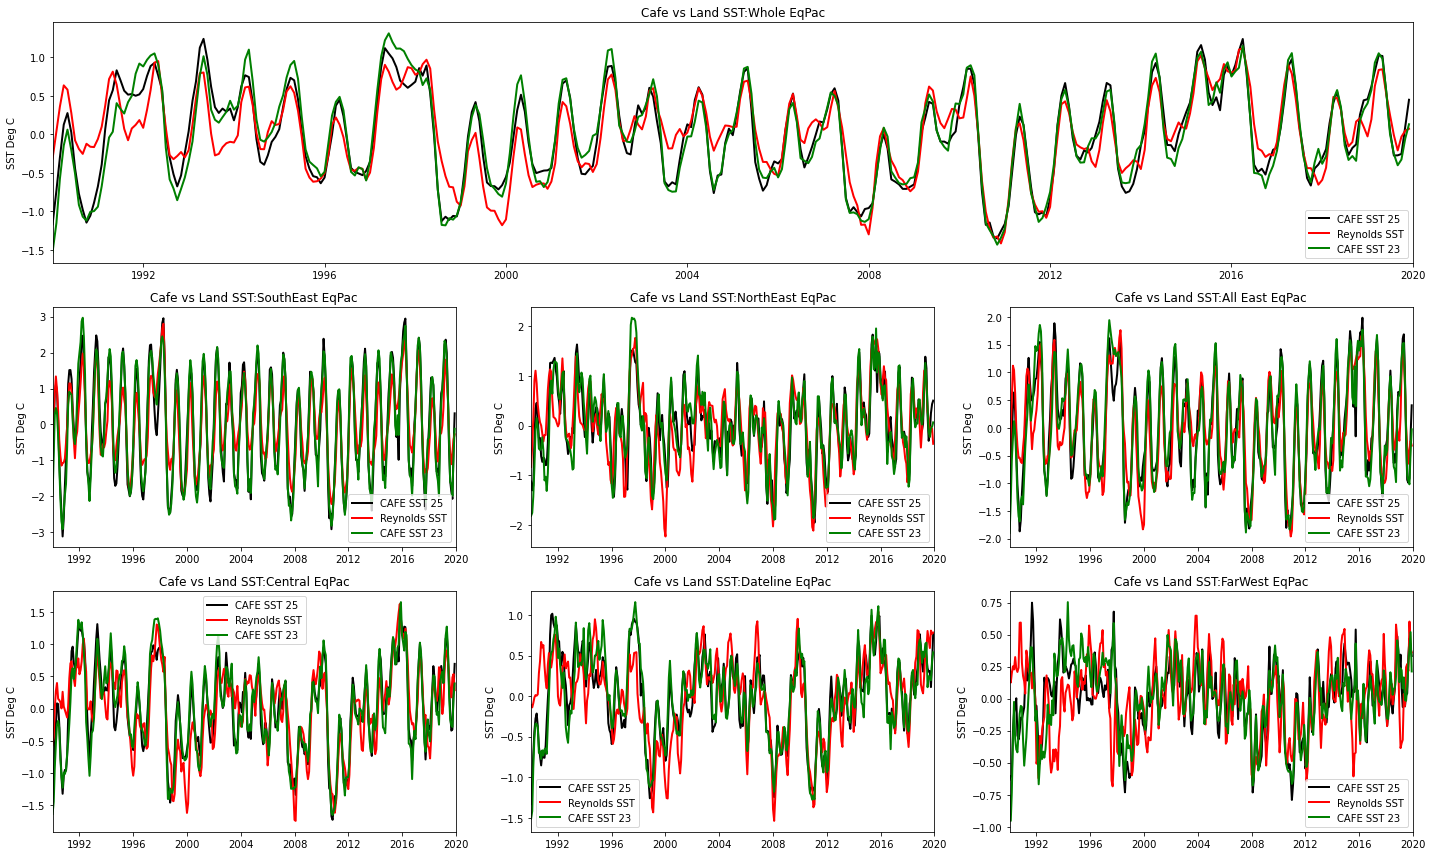

In [60]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.sst.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=sst_rey,
                   var_c=bgcdatvs_allens.sst.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE SST 25',
                   var_b_name='Reynolds SST',
                   var_c_name='CAFE SST 23',
                   units='SST Deg C',
                   title='Cafe vs Land SST:',
                   detrend=True,deseasonalise=False,keep_intercept_values=False)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


0
1
2
3
4
5
6


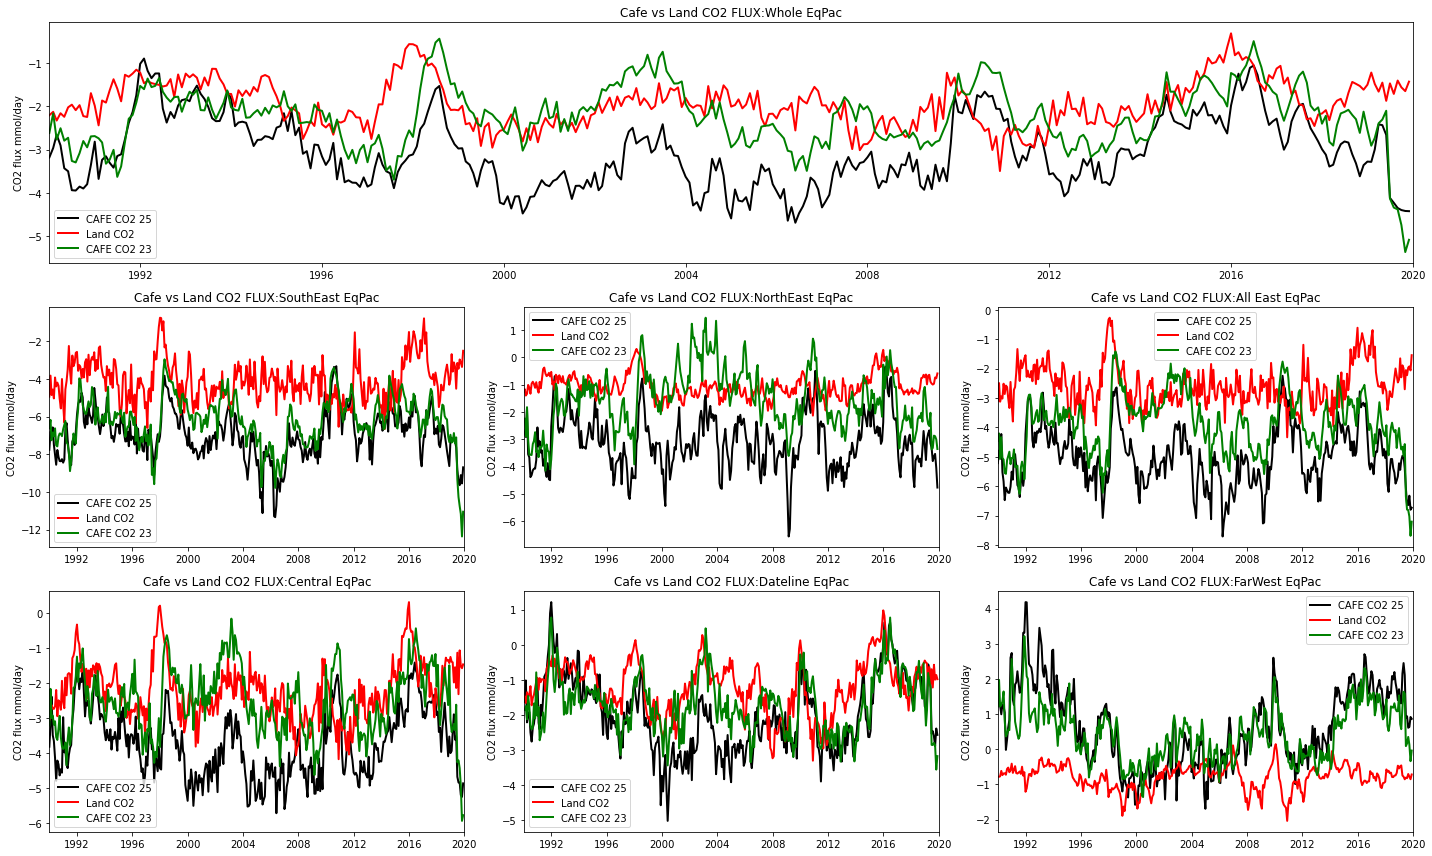

In [61]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.stf10.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=co2_land,
                   var_c=bgcdatvs_allens.stf10.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE CO2 25',
                   var_b_name='Land CO2',
                   var_c_name='CAFE CO2 23',
                   units='CO2 flux mmol/day',
                   title='Cafe vs Land CO2 FLUX:',
                   detrend=True,deseasonalise=True,keep_intercept_values=True)

In [ ]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.stf10.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=co2_land,
                   var_c=bgcdatvs_allens.stf10.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE CO2 25',
                   var_b_name='Land CO2',
                   var_c_name='CAFE CO2 23',
                   units='CO2 flux mmol/day',
                   title='Cafe vs Land CO2 FLUX:',
                   detrend=True,deseasonalise=True,keep_intercept_values=False)

/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,
/local/v45/np1383/tmp/ipykernel_3380390/2074935082.py:31: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  detrended = xr.apply_ufunc(lin_xarray_detrender, x,y,keep_intercept_values,


In [ ]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=bgcdatvs_allens.sst.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01')),
                   var_b=sst_rey,
                   var_c=bgcdatvs_allens.sst.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01')),
                   var_a_name='CAFE SST 25',
                   var_b_name='Reynolds SST',
                   var_c_name='CAFE SST 23',
                   units='SST Deg C',
                   title='Cafe vs Land SST:',
                   detrend=True,deseasonalise=True)

In [ ]:
sst_cafe=bgcdatvs_allens.sst.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('1990-01-01','2020-01-01'))

plot_pacific_boxes(var_a=sst_cafe,
                   var_b=sst_rey,
                   var_a_name='CAFE SST',
                   var_b_name='Reynolds SST',
                   units='SST Deg C',
                   title='Cafe vs Land SST:',
                   detrend=False)#,deseasonalise=True)

In [ ]:
np1_cafe_25=bgcdatvs_allens.det_export.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np1_cafe_23=bgcdatvs_allens.det_export.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np2_cafe=bgcdatvs_allens.trim_export_2d.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np_dat=(np_obs.sel(time=slice('1990-01-01','2020-01-01')))

In [ ]:

plot_pacific_boxes(var_a=np1_cafe_25,
                   var_b=np2_cafe_23,
                   var_c=np_dat,
                   var_a_name='CAFE Det Export',
                   var_b_name='CAFE Laws Export',
                   var_c_name='Laws Cafe export',
                   units='New Production / Export mmol / m2/ day',
                   title='Cafe vs Nic Export:',
                   sdate='2000-01-01')#,detrend=True,deseasonalise=True)

In [ ]:
np1_cafe=bgcdatvs_allens.nics_export.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np2_cafe=bgcdatvs_allens.trim_export_2d.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np_dat=(np_obs.sel(time=slice('1990-01-01','2020-01-01')))

In [ ]:
#land_co2
#rey_sst

#sst #regrid?
#npp CAFE
# *fr.laws2

In [ ]:
# Seasonality?

In [ ]:
# Convert Data for plotting
sst_cafe=bgcdatvs_allens.sst.sel(time=slice('2000-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('2000-01-01','2020-01-01'))
co2_cafe=bgcdatvs_allens.stf10.sel(time=slice('2000-01-01','2020-01-01'))
co2_land=land_co2.sel(time=slice('2000-01-01','2020-01-01'))

In [ ]:
#sst_cafe
#sst_rey

In [ ]:
# Convert Data for plotting
sst_cafe=bgcdatvs_allens.sst.sel(time=slice('2000-01-01','2020-01-01'))
sst_rey=rey_sst.sel(time=slice('2000-01-01','2020-01-01'))
co2_cafe=bgcdatvs_allens.stf10.sel(time=slice('2000-01-01','2020-01-01'))
co2_land=land_co2.sel(time=slice('2000-01-01','2020-01-01'))

npp_cafe_25=bgcdatvs_allens.pprod_gross_2d.sel(ensemble=25).sel(time=slice('1990-01-01','2020-01-01'))*6.625
npp_cafe_23=bgcdatvs_allens.pprod_gross_2d.sel(ensemble=23).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np2_cafe=bgcdatvs_allens.trim_export_2d.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np_dat=(np_obs.sel(time=slice('1990-01-01','2020-01-01')))
plot_pacific_boxes(var_a=npp_cafe_25,
                   var_b=npp_cafe_23,
                   var_c=npp.sel(time=slice('1990-01-01','2020-01-01'))/12,
                   var_a_name='CAFE GPP 25',
                   var_b_name='CAFE GPP 23',
                   var_c_name='Cafe NPP',
                   units='New Production / Export mmol / m2/ day',
                   title='Cafe vs Nic Export:',
                   sdate='2000-01-01',detrend=True,deseasonalise=True,keep_intercept_values=False)

In [ ]:
np2_cafe=bgcdatvs_allens.trim_export_2d.sel(ensemble=26).sel(time=slice('1990-01-01','2020-01-01'))*6.625
np_dat=(np_obs.sel(time=slice('1990-01-01','2020-01-01')))

In [ ]:
sst_rey.groupby('time.month').mean().mean(dim=['lat','lon']).plot()

In [ ]:
plt.figure(figsize=(15,8))
for i in np.arange(15,30):
    sst_cafe.groupby('time.month').mean().mean(dim=['lat','lon']).sel(ensemble=i+1).plot()
sst_rey.groupby('time.month').mean().mean(dim=['lat','lon']).plot(c='k')

In [ ]:
plt.figure(figsize=(15,8))
for i in np.arange(15,30):
    co2_cafe.groupby('time.month').mean().mean(dim=['lat','lon']).sel(ensemble=i+1).plot()
co2_land.groupby('time.month').mean().mean(dim=['lat','lon']).plot(c='k')

In [ ]:
sst_rey.groupby('time.month').mean().mean(dim=['month']).plot()

In [ ]:
sst_rey.groupby('time.month').mean().std(dim=['month']).plot() #STd of Months

In [ ]:


def plot_pacific(dat):

    fig = plt.figure(figsize=(12,7))

    # this declares a recentered projection for Pacific areas
    proj = ccrs.PlateCarree(central_longitude=180)
    proj._threshold /= 20.  # to make greatcircle smooth

    ax = plt.axes(projection=proj)
    # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree())

    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)

    lonm,latm=np.meshgrid(sst_rey.lon,sst_rey.lat)
    g=ax.contourf(dat.lon,dat.lat,dat, transform=ccrs.PlateCarree(),cmap='bwr')
    plt.colorbar(g,ax=ax,location='bottom',orientation='horizontal')
    # plot greatcircle arc

    ax.add_feature(cfeature.LAND, color='lightgray', zorder=100, edgecolor='k')
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    ax.coastlines()

    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)

    plt.show()
    
    
#Seasonality?
#plot_pacific(sst_rey.groupby('time.month').mean().std(dim=['month']))

stat=xarray_get_trend(sst_rey)
plot_pacific(stat.sel(parameter=0)*365)

stat=xarray_get_trend(sst_cafe)
plot_pacific(stat.sel(parameter=0)*365)

In [ ]:
?plt.colorbar

In [ ]:
plt.figure(figsize=(15,8))
#for i in np.arange(15,30):
#    xarray_detrend(co2_cafe).groupby('time.month').mean().mean(dim=['lat','lon']).sel(ensemble=i+1).plot()
#xarray_detrend(co2_land).groupby('time.month').mean().mean(dim=['lat','lon']).plot(c='k')